This script is used to explore different deep learning models with different architecture.

## Standard Import


In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Data"
LABEL_DIR = os.path.join(DATA_DIR,'Label')
DL_DIR =  "/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning"

Mounted at /content/drive


## Import MLFramework & Backtesting

In [4]:
%run '/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/MLFramework.ipynb' import MLFramework

In [5]:
%run '/content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Backtesting.ipynb' import backtesting, backtesting_df

     |████████████████████████████████| 175 kB 13.8 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=086914b683645a0e81a1ab6f15134b696eb523cea582c752af025a298c14f47c
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built backtesting


/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Mounted at /content/drive


# Explore dataset

In [6]:
file_dir = os.path.join(DATA_DIR,'AllData_Simon.csv')
df = pd.read_csv(file_dir,parse_dates=True,index_col=0)
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2925.36,1.300478e+09,0.061,0.076,0.188,0.433,1.630,2.635,3.815,4.637,3.77,2.76,0.25438,0.17,0.12,81.51,81.64,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,1.69,0.61,1.13,0.0,126.5115,NaN,1132.99,3.991400e+09
2010-01-05,2933.82,1.526207e+09,0.046,0.071,0.178,0.389,1.567,2.578,3.777,4.620,3.70,2.76,0.25250,0.18,0.12,81.77,81.47,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.31,-0.64,1.24,0.0,124.9832,NaN,1136.52,2.491020e+09
2010-01-06,2937.47,1.441448e+09,0.023,0.073,0.172,0.394,1.584,2.601,3.809,4.660,3.79,2.84,0.25000,0.19,0.12,83.18,83.25,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.13,-0.22,0.57,0.0,124.1713,NaN,1137.14,4.972660e+09
2010-01-07,2949.90,1.560355e+09,0.028,0.056,0.157,0.382,1.562,2.590,3.812,4.678,3.80,2.82,0.24938,0.20,0.10,82.66,82.69,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.40,0.09,0.98,0.0,123.7415,NaN,1141.69,5.270680e+09
2010-01-08,2959.37,1.311918e+09,0.015,0.053,0.142,0.338,1.550,2.590,3.839,4.723,3.78,2.87,0.25125,0.20,0.11,82.75,82.91,1.0,-269.0,0.0,0.4,1.0,10.0,0.0,2.2,0.33,0.37,0.01,0.0,124.9832,NaN,1144.98,4.389590e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,0.045,0.177,0.368,0.537,1.363,1.650,1.869,2.179,1.66,0.79,0.25514,0.09,0.08,86.96,85.58,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,131.5800,-1.7882,4532.76,3.387370e+09
2022-01-20,14378.11,1.355285e+09,0.035,0.175,0.358,0.542,1.315,1.590,1.810,2.120,1.66,0.75,0.25886,0.08,0.08,86.90,84.67,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,130.8200,-4.0630,4482.73,3.473060e+09
2022-01-21,14099.17,1.917342e+09,0.046,0.177,0.355,0.547,1.291,1.564,1.763,2.080,1.58,0.74,0.25771,0.09,0.08,85.14,85.43,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,129.3500,-6.2267,4397.94,3.945810e+09


In [7]:
labelfile_dir = os.path.join(LABEL_DIR,'label.csv')

label= pd.read_csv(labelfile_dir,parse_dates=True,index_col=0)
label

,PX_LAST,PX_VOLUME,RET,RET10,SIG10,SR10,POS_RET,POS_SR,State_RET,State_SR,State_RET_shifted,State_SR_shifted
Date,,,,,,,,,,,,
2000-01-03,2909.89,1748611000,-0.009045,0.007478,0.020033,1.866374,0,0,-1,-1,1,1
2000-01-04,2795.36,1805332000,-0.039359,0.052923,0.014184,18.656401,1,1,1,1,1,1
2000-01-05,2802.51,2100967000,0.002558,0.045370,0.014514,15.629273,1,1,1,1,1,1
2000-01-06,2784.07,1972651000,-0.006580,0.051195,0.014144,18.097667,1,1,1,1,1,1
2000-01-07,2878.11,2151953000,0.033778,-0.009656,0.013294,-3.631671,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1322548409,-0.010110,-0.069665,0.010564,-32.974359,-1,-1,-1,-1,-1,-1
2022-01-20,14378.11,1355284526,-0.011625,-0.069665,0.010564,-32.974359,-1,-1,-1,-1,-1,-1
2022-01-21,14099.17,1917342177,-0.019400,-0.069665,0.010564,-32.974359,-1,-1,-1,-1,-1,-1


In [8]:
# Merge dataset
master_ds = df.merge(label[['POS_RET','POS_SR','State_RET_shifted','State_SR_shifted']],how="left",left_index=True,right_index=True,sort=True)
master_ds

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2925.36,1.300478e+09,0.061,0.076,0.188,0.433,1.630,2.635,3.815,4.637,3.77,2.76,0.25438,0.17,0.12,81.51,81.64,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,1.69,0.61,1.13,0.0,126.5115,NaN,1132.99,3.991400e+09,1,1,1,1
2010-01-05,2933.82,1.526207e+09,0.046,0.071,0.178,0.389,1.567,2.578,3.777,4.620,3.70,2.76,0.25250,0.18,0.12,81.77,81.47,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.31,-0.64,1.24,0.0,124.9832,NaN,1136.52,2.491020e+09,1,0,1,1
2010-01-06,2937.47,1.441448e+09,0.023,0.073,0.172,0.394,1.584,2.601,3.809,4.660,3.79,2.84,0.25000,0.19,0.12,83.18,83.25,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.13,-0.22,0.57,0.0,124.1713,NaN,1137.14,4.972660e+09,1,-1,1,1
2010-01-07,2949.90,1.560355e+09,0.028,0.056,0.157,0.382,1.562,2.590,3.812,4.678,3.80,2.82,0.24938,0.20,0.10,82.66,82.69,0.0,12.0,0.0,0.4,0.0,10.0,0.0,2.2,0.40,0.09,0.98,0.0,123.7415,NaN,1141.69,5.270680e+09,-1,-1,1,1
2010-01-08,2959.37,1.311918e+09,0.015,0.053,0.142,0.338,1.550,2.590,3.839,4.723,3.78,2.87,0.25125,0.20,0.11,82.75,82.91,1.0,-269.0,0.0,0.4,1.0,10.0,0.0,2.2,0.33,0.37,0.01,0.0,124.9832,NaN,1144.98,4.389590e+09,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,0.045,0.177,0.368,0.537,1.363,1.650,1.869,2.179,1.66,0.79,0.25514,0.09,0.08,86.96,85.58,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,131.5800,-1.7882,4532.76,3.387370e+09,-1,-1,-1,-1
2022-01-20,14378.11,1.355285e+09,0.035,0.175,0.358,0.542,1.315,1.590,1.810,2.120,1.66,0.75,0.25886,0.08,0.08,86.90,84.67,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,130.8200,-4.0630,4482.73,3.473060e+09,-1,-1,-1,-1
2022-01-21,14099.17,1.917342e+09,0.046,0.177,0.355,0.547,1.291,1.564,1.763,2.080,1.58,0.74,0.25771,0.09,0.08,85.14,85.43,0.0,199.0,0.0,0.5,0.0,3.9,0.0,2.1,-0.31,0.06,0.53,0.0,129.3500,-6.2267,4397.94,3.945810e+09,-1,-1,-1,-1


In [9]:
master_ds.describe()

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted
count,3039.000000,3.039000e+03,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3014.000000,3039.000000,3.039000e+03,3039.000000,3039.000000,3039.000000,3039.000000
mean,6850.576199,1.170968e+09,0.474902,0.509646,0.577186,0.654329,1.057263,1.485647,2.187796,2.953198,1.683106,1.339585,0.777988,0.275173,0.545577,69.425791,68.813547,0.047713,146.082922,0.047384,0.178085,0.047713,6.346463,0.031918,2.263014,0.058532,0.002817,-0.009056,0.001822,149.512373,-0.137721,2272.330023,3.823248e+09,0.356367,0.162553,0.354393,0.494571
std,3163.201841,4.174573e+08,0.734809,0.753390,0.769628,0.780535,0.702486,0.663621,0.700611,0.776547,0.920295,0.784298,0.774788,0.144663,0.727530,22.311637,23.401170,0.213194,1741.091677,0.212494,0.242152,0.213194,2.228062,0.175812,6.866107,1.103444,0.589783,0.735575,0.002983,24.449217,5.766886,904.401010,9.584378e+08,0.842629,0.864351,0.688311,0.729258
min,2678.580000,3.694230e+08,-0.061000,-0.048000,0.005000,0.005000,0.101000,0.189000,0.508000,1.022000,-0.520000,-0.040000,0.114130,0.060000,0.040000,-37.630000,7.790000,0.000000,-20679.000000,0.000000,-0.700000,0.000000,3.500000,0.000000,-32.900000,-12.000000,-3.600000,-5.020000,0.000000,90.520900,-29.742200,1022.580000,1.025000e+09,-1.000000,-1.000000,-1.000000,-1.000000
25%,4063.075000,9.509971e+08,0.030000,0.043000,0.084000,0.129000,0.436000,0.908500,1.724000,2.521500,1.110000,0.720000,0.252500,0.180000,0.090000,50.515000,50.595000,0.000000,141.000000,0.000000,0.000000,0.000000,4.400000,0.000000,1.700000,-0.360000,-0.350000,-0.350000,0.000000,130.250950,-3.389550,1464.095000,3.252660e+09,0.000000,-1.000000,0.000000,0.000000
50%,6119.250000,1.075094e+09,0.087000,0.104000,0.155000,0.244000,0.921000,1.506000,2.192000,2.963000,1.650000,1.320000,0.333600,0.240000,0.150000,66.520000,66.740000,0.000000,211.000000,0.000000,0.200000,0.000000,5.800000,0.000000,2.400000,0.080000,0.000000,-0.030000,0.000000,145.452400,0.132800,2089.170000,3.643530e+09,1.000000,0.000000,0.000000,1.000000
75%,8690.290000,1.260752e+09,0.519500,0.581500,0.672500,0.887000,1.461000,1.859500,2.660500,3.317000,2.320000,1.900000,1.149830,0.360000,0.660000,90.785000,90.765000,0.000000,268.000000,0.000000,0.300000,0.000000,8.100000,0.000000,3.200000,0.570000,0.350000,0.320000,0.002000,170.377400,3.541250,2804.090000,4.196505e+09,1.000000,1.000000,1.000000,1.000000
max,15484.000000,4.992361e+09,2.469000,2.471000,2.570000,2.766000,3.050000,3.092000,3.994000,4.829000,3.830000,2.910000,2.823750,1.420000,2.450000,113.930000,113.730000,1.000000,4846.000000,1.000000,0.900000,1.000000,14.700000,1.000000,33.100000,9.340000,5.540000,6.740000,0.010000,206.124400,16.499500,4796.560000,1.061781e+10,1.000000,1.000000,1.000000,1.000000


In [10]:
master_ds.isna().any()

Russell_Close                             False
Russell_Volume                            False
1MTBill                                   False
3MTBill                                   False
6MTBill                                   False
1YTBill                                   False
3YTNotes                                  False
5YTNotes                                  False
10YTNotes                                 False
30YTTreasury                              False
T10Y3M                                    False
T10Y2Y                                    False
3M_USD_LIBOR                              False
TEDRATE                                   False
Fed_eff_Rate                              False
WTI_Futures                               False
WTI_Spot                                  False
non-farm payroll calendar                 False
change in total non-farm(in thousands)    False
CPI calendar                              False
CPI monthly percent change(%)           

In [11]:
master_ds['FG INDEX'].first_valid_index()

Timestamp('2010-02-09 00:00:00')

In [12]:
master_ds.dtypes

Russell_Close                             float64
Russell_Volume                            float64
1MTBill                                   float64
3MTBill                                   float64
6MTBill                                   float64
1YTBill                                   float64
3YTNotes                                  float64
5YTNotes                                  float64
10YTNotes                                 float64
30YTTreasury                              float64
T10Y3M                                    float64
T10Y2Y                                    float64
3M_USD_LIBOR                              float64
TEDRATE                                   float64
Fed_eff_Rate                              float64
WTI_Futures                               float64
WTI_Spot                                  float64
non-farm payroll calendar                 float64
change in total non-farm(in thousands)    float64
CPI calendar                              float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


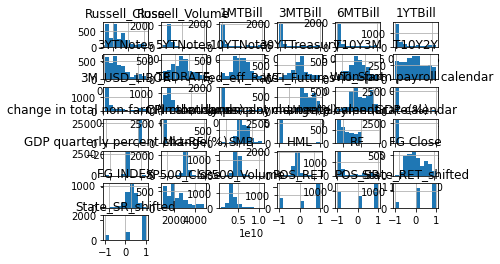

In [36]:
master_ds.hist()
plt.tight_layout()
plt.show()

# TensorFlow

In [14]:
# pip install keras-tuner --upgrade
# import keras_tuner as kt

In [15]:
# pip install tensorflow --upgrade

In [16]:
!pip install tensorflow_addons
import tensorflow_addons as tfa


     |████████████████████████████████| 1.1 MB 13.9 MB/s 


In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN , Dense , LSTM , Dropout, Normalization, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import metrics
from tensorflow_addons.layers import ESN

In [18]:
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Version 2, minor 8


In [19]:
def generateTSdata(X,y, look_back):
    
    X_ts =  np.array([X[i:(i+look_back),:] for i in range(X.shape[0]-look_back+1)])
    y_ts = np.array(y[(look_back-1):,:])
    return X_ts, y_ts

In [20]:
def plotTrain( history, model_name:str, metrics_name:list):
    n = len(metrics_name)+1
    i = math.ceil(n/2)
    j = 2
    fig, axs = plt.subplots( i,j, figsize=(12, 5) )

    # Plot loss
    axs[0,0].plot(history.history['loss'])
    axs[0,0].plot(history.history['val_loss'])
    axs[0,0].set_title(model_name + " " + 'model loss')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_xlabel('epoch')
    axs[0,0].legend(['train', 'validation'], loc='upper left')
   
    # Plot accuracy
    for k in range(len(metrics_name)):
      i = math.floor((k+1)/2)
      j = (k+1)%2
      acc_string = metrics_name[k]
      axs[i,j].plot(history.history[ acc_string ])
      axs[i,j].plot(history.history['val_' + acc_string ])
      axs[i,j].set_title(model_name + " " +'model '+acc_string)
      axs[i,j].set_ylabel(acc_string)
      axs[i,j].set_xlabel('epoch')
      axs[i,j].legend(['train', 'validation'], loc='upper left')

    return fig, axs

In [21]:
def showResult(model, X_val_ts,y_val_ts):
    score = model.evaluate(X_val_ts,y_val_ts)
    y_pred = model.predict(X_val_ts)
    print(confusion_matrix(y_val_ts.argmax(axis=1),y_pred.argmax(axis=1)) ) 
    print('Validation Score: ',score)
    print('Validation Prediction: \n',y_pred)
    return

In [22]:
def standardization(X_train,X_val,X_test):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)
  return X_train, X_val, X_test


In [23]:
def overSampling(X_train_Val, y_train_val, jittering=False, numFeatures_colList = [1,2,3], variance = 0.1):
  ### input training dataset or validation dataset; 
  ### y has to be a 3-columns 2-d matrix (n,3)   
  ### X is a 3-d matrix (n, sequence, features)

  Nclass = y_train_val.shape[1]
  Xy_class = []
  ids_class=[]
  print('Before Resmapling:')
  print('X.Shape ',X_train_Val.shape)
  print('y.Shape ',y_train_val.shape)
  for i in range(Nclass):
    ids_class.append( y_train_val[:,i] == 1)
    Xy_class.append((X_train_Val[ids_class[i],:,:], y_train_val[ids_class[i],:]) )
    print(i,Xy_class[i][0].shape)

  print('After Resmapling:')
  n_class = [ind.sum() for ind in ids_class]
  max_n = max(n_class)
  # res_Xy_class =[]
  for i in range(Nclass):
    if n_class[i]!=max_n:
      ids = np.arange(len(Xy_class[i][0] ))
      choices = np.random.choice(ids, max_n- n_class[i])
      X = Xy_class[i][0]
      y = Xy_class[i][1]
      dup_X = X[choices,:,:]
      dup_y = y[choices,:]
      if jittering:
        dup_X[:,:,numFeatures_colList] + np.random.normal(0, variance, ( max_n- n_class[i], X.shape[1], len(numFeatures_colList) ))
      
      res_X = np.concatenate((X,dup_X),axis=0)
      res_y = np.concatenate((y,dup_y),axis=0)
      Xy_class[i] =  ( res_X , res_y)
    print(i,Xy_class[i][0].shape)

  res_X = np.concatenate([Xy_class[i][0] for i in range(Nclass)],axis=0)
  res_y = np.concatenate([Xy_class[i][1] for i in range(Nclass)],axis=0)
  print('X.Shape after resampling',res_X.shape)
  print('y.Shape after resampling',res_y.shape)

  return res_X, res_y



In [24]:
model = {}
history = {}

## Master Control

In [25]:
# targetLabel = 'POS_SR'
# Target = targetLabel 
# allHMM = False

targetLabel = 'hmm2_MA10'
Target = targetLabel+'_shifted'
allHMM = True
look_back = 180
fileName = 'master_ds_v6.csv'


## Read Data - master_ds_v6

In [26]:
df_dir = os.path.join(LABEL_DIR,fileName)
df = pd.read_csv(df_dir, parse_dates=True, index_col=0)
df

,PX_LAST,PX_VOLUME,SPXT_Close,SPXT_Volume,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,Mkt-RF,SMB,HML,RF,...,month_8,month_9,month_10,month_11,month_12,PX_Ret,SPXT_Ret,VIX_Close_Diff,Mkt-RF_Diff,SMB_Diff,HML_Diff,RF_Diff,T1M_Diff,T3M_Diff,T6M_Diff,T1Y_Diff,T3Y_Diff,T5Y_Diff,T10Y_Diff,T30Y_Diff,T10Y3M_Diff,T10Y2Y_Diff,LIBOR_3M_Diff,TEDRATE_Diff,InterestRate_Diff,PX_EMA5,PX_EMA10,PX_EMA5_BB_hband,PX_EMA5_BB_lband,PX_EMA5_BB_pband,PX_KAMA10,PX_EMA5_RSI,PX_EMA5_MACD,PX_EMA5_MACD_Diff,PX_EMA5_MACD_Sig,PX_EMA5_VPT,PX_EMA5_FI,PX_EMA5_KST,PX_EMA5_KST_Diff,PX_EMA5_KST_Sig
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-02,585.41,0,386.16,0,NaN,7.83,7.50,7.81,7.90,7.87,7.94,8.00,0.11,0.07,8.38000,0.80,8.54,22.89,0.0490,22.89,0.0490,158.6294,-0.8405,69.0585,190.157,17.2194,2.3009,0.3,0,5.4,0,276,0,17.240000,0.8,0,1.44,-0.68,-0.07,0.026,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,585.05,0,385.17,0,NaN,7.89,7.53,7.85,7.96,7.92,7.99,8.04,0.10,0.05,8.38000,0.75,8.37,23.68,0.0345,23.68,0.0345,166.5505,-6.7745,68.4778,190.767,18.4101,3.0652,0.3,0,5.4,0,276,0,18.190001,0.8,0,-0.06,0.74,-0.26,0.026,...,0,0,0,0,0,-0.000615,-0.002567,0.950001,-1.50,1.42,-0.19,0.0,NaN,0.06,0.03,0.04,0.06,0.05,0.05,0.04,-0.01,-0.02,0.00000,-0.05,-0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,580.97,0,382.02,0,NaN,7.84,7.50,7.82,7.93,7.91,7.98,8.04,0.14,0.06,8.38000,0.79,8.29,23.41,-0.0114,23.41,-0.0114,104.2355,-19.9820,61.8875,191.575,18.1196,1.8271,0.3,0,5.4,0,276,0,19.219999,0.8,0,-0.71,0.42,-0.22,0.026,...,0,0,0,0,0,-0.006998,-0.008212,1.029998,-0.65,-0.32,0.04,0.0,NaN,-0.05,-0.03,-0.03,-0.03,-0.01,-0.01,0.00,0.04,0.01,0.00000,0.04,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,575.74,0,378.30,0,NaN,7.79,7.46,7.79,7.94,7.92,7.99,8.06,0.20,0.09,8.38000,0.84,8.20,23.08,-0.0141,23.08,-0.0141,56.8323,-36.1185,54.9317,192.319,17.4400,-0.2747,0.3,0,5.4,0,84,1,20.110001,0.8,0,-0.85,0.77,-0.21,0.026,...,0,0,0,0,0,-0.009043,-0.009785,0.890002,-0.14,0.35,0.01,0.0,NaN,-0.05,-0.04,-0.03,0.01,0.01,0.01,0.02,0.06,0.03,0.00000,0.05,-0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,577.78,0,380.04,0,NaN,7.79,7.49,7.81,7.95,7.92,8.02,8.09,0.23,0.12,8.38000,0.84,8.27,21.62,-0.0633,21.62,-0.0633,43.9596,-30.0539,56.8927,193.003,16.6146,-0.5619,0.3,0,5.4,0,84,0,20.260000,0.8,0,0.30,-0.41,-0.26,0.026,...,0,0,0,0,0,0.003537,0.004589,0.149999,1.15,-1.18,-0.05,0.0,NaN,0.00,0.03,0.02,0.01,0.00,0.03,0.03,0.03,0.03,0.00000,0.00,0.07,580.024444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1322548409,9503.14,636487918,0.05,0.17,0.36,0.57,1.33,1.62,1.83,2.14,1.66,0.79,0.25514,0.09,0.08,86.96,0.0179,85.58,-0.0135,-167.3056,-99.3827,32.9727,2780.178,21.6253,-124.8524,0.5,0,3.9,0,199,0,23.850000,2.3,0,-0.31,0.06,0.53,0.000,...,0,0,0,0,0,-0.010162,-0.009717,1.059999,0.00,0.00,0.00,0.0,0.0,0.01,-0.01,-0.01,-0.02,-0.03,-0.04,-0.04,-0.05,-0.02,0.00114,0.01,0.00,14811.486580,14957.90893,15526.74275,14852.27144,-0.060469,14920.04681,29.760884,-33.449827,-53.392657,19.942830,-23996612.05,-7.060297e+10,2.967893,-6.465715,9.433608
2022-01-20,

In [27]:
dataSummary_dir = os.path.join(LABEL_DIR,'DatasetSummary.xlsx')
numFeat = pd.read_excel(dataSummary_dir,sheet_name='v5_numFeat',header=None)
numFeat = numFeat.values.reshape(-1)

label_List = pd.read_excel(dataSummary_dir,sheet_name='v5_label',header=None)
label_List = label_List.values.reshape(-1)

catFeat = pd.read_excel(dataSummary_dir,sheet_name='v5_catFeat',header=None)
catFeat = catFeat.values.reshape(-1)

# targetLabel = 'hmm1_EWMA10'
# Target = targetLabel+'_shifted'



In [28]:
if allHMM:
  numFeat_sub =   numFeat.tolist()
else:
  numFeat_sub = [feat for feat in numFeat if 'hmm' not in feat or targetLabel in feat ]
numFeat_sub

['PX_LAST',
 'PX_VOLUME',
 'SPXT_Close',
 'SPXT_Volume',
 'T1M',
 'T3M',
 'T6M',
 'T1Y',
 'T3Y',
 'T5Y',
 'T10Y',
 'T30Y',
 'T10Y3M',
 'T10Y2Y',
 'LIBOR_3M',
 'TEDRATE',
 'InterestRate',
 'WTI_Futures_Price',
 'WTI_Futures_Return',
 'WTI_Spot_Price',
 'WTI_Spot_Change',
 'Commdity_channel_index_13',
 'Williams_pct_14',
 'RSI_14',
 'Parabolic_0.02_0.2_0.02',
 'DMI_14_ADX',
 'Fear_Greedy_Index',
 'CPI_monthly percent change',
 'Unemployment_rate',
 'change_in_total_nonfarm_thousand',
 'VIX_Close',
 'GDP_QOQ_change',
 'Mkt-RF',
 'SMB',
 'HML',
 'RF',
 'Russell3000_Adj_Close',
 'Russell3000_Volume',
 'hmm1_duration_bear',
 'hmm1_duration_static',
 'hmm1_duration_bull',
 'hmm1_MA5_duration_bear',
 'hmm1_MA5_duration_static',
 'hmm1_MA5_duration_bull',
 'hmm1_MA10_duration_bear',
 'hmm1_MA10_duration_static',
 'hmm1_MA10_duration_bull',
 'hmm1_MA15_duration_bear',
 'hmm1_MA15_duration_static',
 'hmm1_MA15_duration_bull',
 'hmm1_EWMA5_duration_bear',
 'hmm1_EWMA5_duration_static',
 'hmm1_EWMA

In [29]:
if allHMM:
  catFeat_sub =   catFeat.tolist()
else:
  catFeat_sub = [feat for feat in catFeat if 'hmm' not in feat or targetLabel in feat ]
catFeat_sub

['CPI_Release',
 'Unemployment_Release',
 'Nonfarm_Release',
 'GDP_Release',
 'hmm1',
 'hmm1_MA5',
 'hmm1_MA10',
 'hmm1_MA15',
 'hmm1_EWMA5',
 'hmm1_EWMA10',
 'hmm1_EWMA15',
 'hmm2',
 'hmm2_MA5',
 'hmm2_MA10',
 'hmm2_MA15',
 'hmm2_EWMA5',
 'hmm2_EWMA10',
 'hmm2_EWMA15',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [30]:
Features = numFeat_sub + catFeat_sub
ds = df.loc['2002-01-01':'2022-01-24', Features + [Target]]
ds

,PX_LAST,PX_VOLUME,SPXT_Close,SPXT_Volume,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,Unemployment_rate,change_in_total_nonfarm_thousand,VIX_Close,GDP_QOQ_change,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,hmm1_duration_bear,hmm1_duration_static,...,PX_EMA5_MACD_Sig,PX_EMA5_VPT,PX_EMA5_FI,PX_EMA5_KST,PX_EMA5_KST_Diff,PX_EMA5_KST_Sig,CPI_Release,Unemployment_Release,Nonfarm_Release,GDP_Release,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm2,hmm2_MA5,hmm2_MA10,hmm2_MA15,hmm2_EWMA5,hmm2_EWMA10,hmm2_EWMA15,weekday_1,weekday_2,weekday_3,weekday_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hmm2_MA10_shifted
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-02,2418.16,2344382000,1628.51,1432406600,1.73,1.74,1.81,2.28,3.75,4.52,5.20,5.56,3.46,1.98,1.86000,0.15,1.92,21.01,0.0590,20.06,0.0111,39.5466,-17.9055,56.9590,614.690,11.2783,20.6646,-0.3,5.3,-312,22.709999,-1.6,0.42,-0.64,0.17,0.007,637.270019,0,0.0,0.0,...,16.981453,-2.136852e+05,5.822147e+09,21.975458,-4.117875,26.093332,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2002-01-03,2442.57,3160795000,1643.48,1879274400,1.73,1.73,1.78,2.24,3.71,4.48,5.16,5.54,3.43,1.97,1.88000,0.18,1.72,20.37,-0.0305,20.77,0.0354,127.2062,-0.1199,61.2367,615.820,11.0575,23.8914,-0.3,5.3,-312,21.340000,-1.6,0.99,0.85,-0.40,0.007,643.700012,0,0.0,0.0,...,17.078848,1.465034e+07,9.316379e+09,22.047590,-2.746845,24.794435,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2002-01-04,2459.80,3289117000,1653.69,1947891600,1.72,1.72,1.78,2.25,3.72,4.50,5.18,5.57,3.46,1.99,1.87000,0.18,1.61,21.62,0.0614,21.18,0.0197,176.4276,-4.5618,63.9613,617.492,11.5112,28.4725,-0.3,5.3,-160,20.450001,-1.6,0.70,0.10,0.39,0.007,648.239990,0,0.0,0.0,...,17.432610,2.900867e+07,1.368517e+10,21.851281,-1.904816,23.756097,0,0,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
2002-01-07,2442.45,3019993000,1642.95,1685144300,1.70,1.68,1.73,2.19,3.61,4.39,5.09,5.49,3.41,2.01,1.87000,0.21,1.61,21.48,-0.0065,21.38,0.0094,133.1437,-22.2527,59.4282,620.091,11.9978,25.5654,-0.3,5.3,-160,21.940001,-1.6,-0.70,-0.43,0.85,0.007,643.669983,0,0.0,0.0,...,17.925531,1.931985e+07,1.272395e+10,21.822583,-1.180675,23.003259,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2002-01-08,2437.00,2692446000,1637.48,1540325600,1.70,1.68,1.74,2.19,3.60,4.39,5.10,5.51,3.42,2.03,1.84000,0.19,1.61,21.25,-0.0107,21.23,-0.0070,69.0855,-34.7333,57.8837,623.144,11.9570,19.5850,-0.3,5.3,-160,21.830000,-1.6,-0.23,1.17,0.29,0.007,642.070007,0,0.0,0.0,...,18.434495,2.545968e+06,1.079817e+10,21.916955,-0.581757,22.498711,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-18,14695.80,1495989572,9595.93,753096554,0.05,0.16,0.37,0.58,1.35,1.65,1.87,2.18,1.71,0.81,0.25400,0.08,0.08,85.43,0.0208,86.75,0.0287,-141.7259,-97.2577,36.1204,2788.079,20.1951,-99.6519,0.5,3.9,199,22.790001,2.3,-0.31,0.06,0.53,0.000,2660.810059,0,1.0,0.0,...,33.290994,-1.559425e+07,-5.324468e+10,6.339435,-3.912281,10.251716,0,0,0,0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0
2022-01-19,14547.22,1322548409,9503.14,636

In [31]:
ds.isna().any().any()

False

In [32]:
ML_obj = MLFramework(Target,Features,df=ds)  
_ = ML_obj.train_val_test_split()
_ = ML_obj.target_transform_cat()

In [33]:
# look_back = 60
# val_ratio = 0.3

# Train Val Test split
# X_train, X_val, y_train, y_val = train_test_split(ML_obj.X_train.values, ML_obj.y_train_trans.values, test_size=0.3,shuffle=False)
# X_test, y_test = ML_obj.X_test.values, ML_obj.y_test_trans.values
X_train, X_val, X_test = ML_obj.X_train.values, ML_obj.X_val.values, ML_obj.X_test.values
y_train, y_val, y_test = ML_obj.y_train_trans.values, ML_obj.y_val_trans.values, ML_obj.y_test_trans.values

# Standardization by X_train
X_train, X_val, X_test = standardization(X_train, X_val ,X_test)

X_temp = np.concatenate([X_val,X_test],axis=0)
y_temp = np.concatenate([y_val,y_test],axis=0)

X_train_ts, y_train_ts = generateTSdata(X_train, y_train, look_back) 
X_temp_ts, y_temp_ts = generateTSdata(X_temp, y_temp, look_back) 
nVal = X_val.shape[0]
X_val_ts_raw, y_val_ts_raw = X_temp_ts[:(nVal-look_back+1)],y_temp_ts[:(nVal-look_back+1)]
X_test_ts, y_test_ts  = X_temp_ts[(nVal-look_back+1):],y_temp_ts[(nVal-look_back+1):]

numFeat_idx_X = [ ML_obj.X_train.columns.get_loc(feat) for feat in numFeat_sub ]
X_train_ts, y_train_ts = overSampling(X_train_ts, y_train_ts, jittering=True, numFeatures_colList = numFeat_idx_X, variance = 0.1)
X_val_ts, y_val_ts = overSampling(X_val_ts_raw, y_val_ts_raw, jittering=True, numFeatures_colList = numFeat_idx_X, variance = 0.1)


print('X_train.shape: ',X_train_ts.shape)
print('y_train.shape: ',y_train_ts.shape)
print('X_val.shape: ',X_val_ts.shape)
print('y_val.shape: ',y_val_ts.shape)
print('X_test.shape: ',X_test_ts.shape)
print('y_test.shape: ',y_test_ts.shape)

Before Resmapling:
X.Shape  (2844, 180, 148)
y.Shape  (2844, 3)
0 (743, 180, 148)
1 (378, 180, 148)
2 (1723, 180, 148)
After Resmapling:
0 (1723, 180, 148)
1 (1723, 180, 148)
2 (1723, 180, 148)
X.Shape after resampling (5169, 180, 148)
y.Shape after resampling (5169, 3)
Before Resmapling:
X.Shape  (828, 180, 148)
y.Shape  (828, 3)
0 (83, 180, 148)
1 (49, 180, 148)
2 (696, 180, 148)
After Resmapling:
0 (696, 180, 148)
1 (696, 180, 148)
2 (696, 180, 148)
X.Shape after resampling (2088, 180, 148)
y.Shape after resampling (2088, 3)
X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
X_test.shape:  (1023, 180, 148)
y_test.shape:  (1023, 3)


In [34]:
train_date = ML_obj.X_train.index[look_back-1:,]
val_date = ML_obj.X_val.index[look_back-1:,]
test_date = ML_obj.X_test.index[look_back-1:,]


## Baseline Model

In [ ]:
def createModel_Baseline(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=200):
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    model.add( Normalization(axis=None))
    model.add(SimpleRNN(16,activation='tanh', dropout=0.1, return_sequences=True))
    # model.add(SimpleRNN(16,activation='relu' )
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 180, 96)          3         
 n)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 180, 16)           1808      
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dropout (Dropout)           (None, 2880)              0         
                                                                 
 head (Dense)                (None, 3)                 8643      
                                                                 
Total params: 10,454
Trainable params: 10,451
Non-trainable params: 3
____________________________________________________

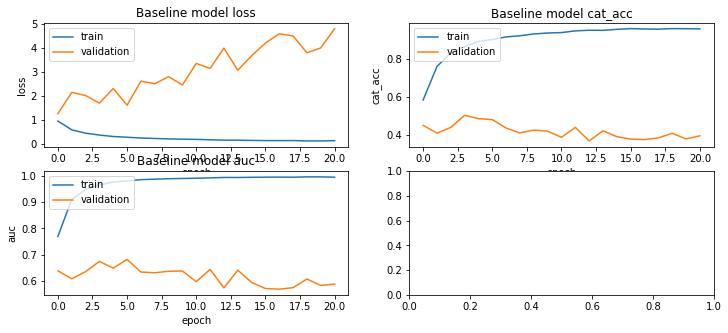

In [ ]:
model_Baseline, history = createModel_Baseline('Baseline', X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
# confusion metrix
showResult(model_Baseline, X_val_ts,y_val_ts)

74/74 [==============================] - 2s 24ms/step - loss: 1.2498 - cat_acc: 0.4508 - auc: 0.6381
[[759  30   0]
 [672  57  60]
 [469  69 251]]
Validation Score:  [1.2498459815979004, 0.45078158378601074, 0.6381278038024902]
Validation Prediction: 
 [[0.74826753 0.16145925 0.09027329]
 [0.6340918  0.2002394  0.16566882]
 [0.7342312  0.21859135 0.04717752]
 ...
 [0.6865564  0.13133574 0.18210787]
 [0.68314487 0.09768373 0.21917145]
 [0.72696924 0.11329681 0.15973394]]


## Baseline Model 2

In [ ]:
def createModel_Baseline2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=150):
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    model.add( Normalization(axis=None))
    model.add(SimpleRNN(32,activation='tanh', dropout=0.1, return_sequences=True))
    model.add(SimpleRNN(16,activation='tanh' ))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 180, 96)          3         
 ion)                                                            
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 180, 32)           4128      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 head (Dense)                (None, 3)                 51        
                                                      

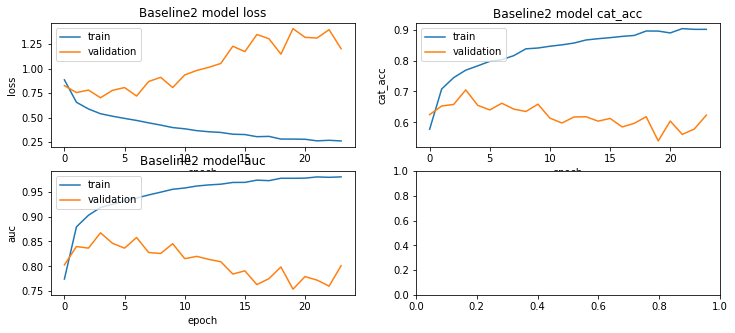

In [ ]:
model_Baseline2, history = createModel_Baseline2('Baseline2', X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
showResult(model_Baseline2, X_val_ts,y_val_ts)

74/74 [==============================] - 3s 41ms/step - loss: 0.7035 - cat_acc: 0.7051 - auc: 0.8674
[[352 426  11]
 [ 36 593 160]
 [  1  64 724]]
Validation Score:  [0.7035358548164368, 0.7051119804382324, 0.867359459400177]
Validation Prediction: 
 [[0.28535172 0.5280386  0.18660967]
 [0.6007215  0.38394642 0.01533213]
 [0.74728656 0.24524815 0.00746524]
 ...
 [0.0115404  0.03878135 0.9496783 ]
 [0.01403832 0.02784159 0.9581201 ]
 [0.01807085 0.05270446 0.92922467]]


## Baseline Model 3

In [ ]:
def createModel_Baseline3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=150):
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( Normalization(axis=None))
    model.add(SimpleRNN(32,activation='tanh', dropout=0.1, return_sequences=True))
    model.add(SimpleRNN(16,activation='tanh' , return_sequences=True))
    model.add(Flatten())
    # model.add(Dropout(0.2))
    # model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    # model.add(layers.Dense(units = 32 ,  activation = 'relu', name='Dense2'))
    # model.add(layers.Dense(units = 16 ,  activation = 'relu', name='Dense3'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense4'))
    model.add(layers.Dense(units = 32 ,  activation = 'relu', name='Dense5'))
    model.add(layers.Dense(units = 8 , activation = 'relu', name='Dense6'))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 180, 32)           4128      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 180, 16)           784       
                                                                 
 flatten_4 (Flatten)         (None, 2880)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2880)              0         
                                                                 
 Dense4 (Dense)              (None, 64)                184384    
                                                                 
 Dense5 (Dense)              (None, 32)                2080      
                                                                 
 Dense6 (Dense)              (None, 8)                

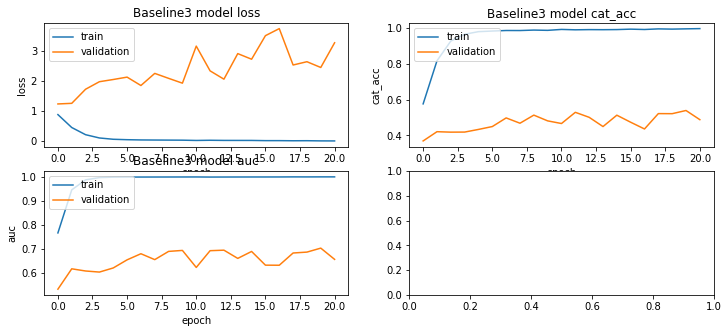

In [ ]:
modelName = 'Baseline3'
model[modelName], history[modelName] = createModel_Baseline3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
showResult(model[modelName], X_val_ts,y_val_ts)

74/74 [==============================] - 3s 39ms/step - loss: 1.2399 - cat_acc: 0.3692 - auc: 0.5341
[[ 50  88 651]
 [ 32 115 642]
 [ 13  67 709]]
Validation Score:  [1.239904761314392, 0.3692437708377838, 0.5340616106987]
Validation Prediction: 
 [[0.10285867 0.17215323 0.7249881 ]
 [0.1295063  0.15286529 0.7176284 ]
 [0.14374048 0.22428958 0.6319699 ]
 ...
 [0.34913975 0.16021103 0.49064928]
 [0.35056055 0.23263621 0.41680324]
 [0.39069286 0.19396603 0.4153411 ]]


## LSTM

In [ ]:
def createModel_LSTM(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(LSTM(32,activation='tanh', dropout=0.1, return_sequences=False))
    # model.add(LSTM(16,activation='tanh' ))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                16512     
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 head (Dense)                (None, 3)                 99        
                                                                 
Total params: 16,611
Trainable params: 16,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
145/146 [============================>.] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


146/146 [==============================] - 17s 89ms/step - loss: 0.7918 - cat_acc: 0.6304 - auc: 0.8279 - val_loss: 0.9631 - val_cat_acc: 0.4744 - val_auc: 0.7328
Epoch 2/100
145/146 [============================>.] - ETA: 0s - loss: 0.5780 - cat_acc: 0.7550 - auc: 0.9115

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


146/146 [==============================] - 11s 76ms/step - loss: 0.5768 - cat_acc: 0.7560 - auc: 0.9120 - val_loss: 0.8173 - val_cat_acc: 0.5754 - val_auc: 0.8073
Epoch 3/100
145/146 [============================>.] - ETA: 0s - loss: 0.4958 - cat_acc: 0.7918 - auc: 0.9333

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


146/146 [==============================] - 11s 76ms/step - loss: 0.4959 - cat_acc: 0.7912 - auc: 0.9332 - val_loss: 0.7446 - val_cat_acc: 0.6025 - val_auc: 0.8439
Epoch 4/100
145/146 [============================>.] - ETA: 0s - loss: 0.4439 - cat_acc: 0.8157 - auc: 0.9461

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


146/146 [==============================] - 12s 81ms/step - loss: 0.4438 - cat_acc: 0.8156 - auc: 0.9461 - val_loss: 0.7430 - val_cat_acc: 0.6451 - val_auc: 0.8420
Epoch 5/100
145/146 [============================>.] - ETA: 0s - loss: 0.4112 - cat_acc: 0.8276 - auc: 0.9533

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM.ckpt/assets


146/146 [==============================] - 11s 76ms/step - loss: 0.4118 - cat_acc: 0.8272 - auc: 0.9532 - val_loss: 0.6922 - val_cat_acc: 0.6667 - val_auc: 0.8649
Epoch 6/100
146/146 [==============================] - 5s 37ms/step - loss: 0.3690 - cat_acc: 0.8500 - auc: 0.9629 - val_loss: 0.7486 - val_cat_acc: 0.6341 - val_auc: 0.8571
Epoch 7/100
146/146 [==============================] - 5s 37ms/step - loss: 0.3462 - cat_acc: 0.8555 - auc: 0.9670 - val_loss: 0.6982 - val_cat_acc: 0.6582 - val_auc: 0.8652
Epoch 8/100
146/146 [==============================] - 5s 37ms/step - loss: 0.3259 - cat_acc: 0.8699 - auc: 0.9711 - val_loss: 0.8058 - val_cat_acc: 0.6316 - val_auc: 0.8419
Epoch 9/100
146/146 [==============================] - 5s 37ms/step - loss: 0.3012 - cat_acc: 0.8807 - auc: 0.9751 - val_loss: 0.7433 - val_cat_acc: 0.6561 - val_auc: 0.8519
Epoch 10/100
146/146 [==============================] - 5s 36ms/step - loss: 0.2850 - cat_acc: 0.8837 - auc: 0.9779 - val_loss: 0.7877 - val_

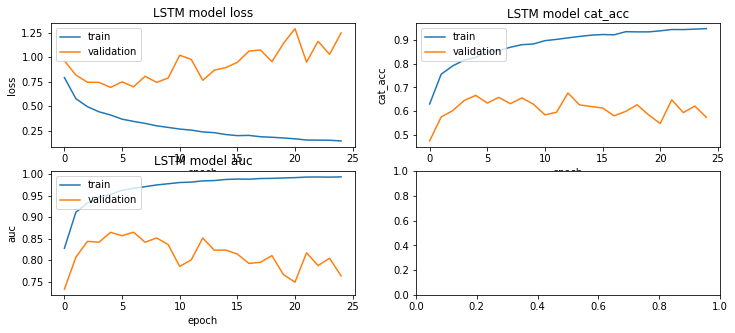

In [ ]:
# model_LSTM, history = createModel_LSTM('LSTM', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'LSTM'
model[modelName], history[modelName] = createModel_LSTM(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
showResult(model[modelName], X_val_ts,y_val_ts)

74/74 [==============================] - 1s 15ms/step - loss: 0.6922 - cat_acc: 0.6667 - auc: 0.8649
[[570 152  67]
 [162 236 391]
 [  1  16 772]]
Validation Score:  [0.6921627521514893, 0.6666666865348816, 0.8649070262908936]
Validation Prediction: 
 [[0.27283213 0.6798099  0.04735787]
 [0.61988616 0.36761883 0.01249506]
 [0.5452436  0.41074097 0.0440154 ]
 ...
 [0.01647131 0.06399359 0.9195351 ]
 [0.01958588 0.06483199 0.9155821 ]
 [0.01860622 0.07456185 0.9068319 ]]


## LSTM2

In [ ]:
def createModel_LSTM2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(LSTM(64,activation='tanh', dropout=0.1, return_sequences=True))
    model.add(LSTM(32,activation='tanh', return_sequences=True))
    model.add(LSTM(16,activation='tanh', return_sequences=False))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 180, 64)           41216     
                                                                 
 lstm_2 (LSTM)               (None, 180, 32)           12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 flatten_6 (Flatten)         (None, 16)                0         
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 head (Dense)                (None, 3)                 51        
        

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM2.ckpt/assets


146/146 [==============================] - 43s 250ms/step - loss: 0.8681 - cat_acc: 0.5823 - auc: 0.7821 - val_loss: 1.1895 - val_cat_acc: 0.4102 - val_auc: 0.6207
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.6594 - cat_acc: 0.7034 - auc: 0.8802

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM2.ckpt/assets


146/146 [==============================] - 35s 242ms/step - loss: 0.6594 - cat_acc: 0.7034 - auc: 0.8802 - val_loss: 1.1097 - val_cat_acc: 0.4829 - val_auc: 0.6831
Epoch 3/100
146/146 [==============================] - 19s 130ms/step - loss: 0.5388 - cat_acc: 0.7605 - auc: 0.9194 - val_loss: 1.1972 - val_cat_acc: 0.4537 - val_auc: 0.6890
Epoch 4/100
146/146 [==============================] - 19s 130ms/step - loss: 0.4508 - cat_acc: 0.7974 - auc: 0.9424 - val_loss: 1.5659 - val_cat_acc: 0.4178 - val_auc: 0.6836
Epoch 5/100
146/146 [==============================] - 19s 130ms/step - loss: 0.4004 - cat_acc: 0.8319 - auc: 0.9545 - val_loss: 1.1284 - val_cat_acc: 0.6181 - val_auc: 0.7774
Epoch 6/100
146/146 [==============================] - 19s 130ms/step - loss: 0.3670 - cat_acc: 0.8465 - auc: 0.9618 - val_loss: 1.4133 - val_cat_acc: 0.5712 - val_auc: 0.7271
Epoch 7/100
146/146 [==============================] - 19s 129ms/step - loss: 0.3326 - cat_acc: 0.8618 - auc: 0.9682 - val_loss: 1.1

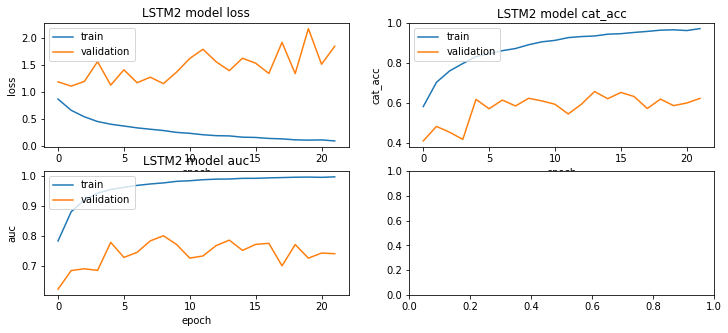

In [ ]:
# model_LSTM2, history = createModel_LSTM2('LSTM2', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'LSTM2'
model[modelName], history[modelName] = createModel_LSTM2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'LSTM2'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

LSTM2 : 
74/74 [==============================] - 3s 47ms/step - loss: 1.1097 - cat_acc: 0.4829 - auc: 0.6831
[[ 94 460 235]
 [ 16 324 449]
 [  0  64 725]]
Validation Score:  [1.1097373962402344, 0.48288974165916443, 0.6831035614013672]
Validation Prediction: 
 [[0.04805465 0.19942406 0.7525213 ]
 [0.08095451 0.32739085 0.5916546 ]
 [0.08461602 0.37045315 0.5449308 ]
 ...
 [0.11447318 0.21974942 0.6657774 ]
 [0.11788034 0.22678275 0.6553369 ]
 [0.12757574 0.23808311 0.6343411 ]]


## LSTM3 (more dense layer after flatten)

In [37]:
def createModel_LSTM3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(LSTM(64,activation='tanh', dropout=0.1, return_sequences=True,name='LSTM1'))
    model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM2'))
    model.add(LSTM(16,activation='tanh', return_sequences=False,name='LSTM3'))
    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 180, 64)           54528     
                                                                 
 LSTM2 (LSTM)                (None, 180, 32)           12416     
                                                                 
 LSTM3 (LSTM)                (None, 16)                3136      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 Dense1 (Dense)              (None, 64)                1088      
        

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


162/162 [==============================] - 69s 387ms/step - loss: 0.8991 - cat_acc: 0.5338 - auc: 0.7547 - val_loss: 0.9056 - val_cat_acc: 0.6078 - val_auc: 0.7692
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.6430 - cat_acc: 0.7154 - auc: 0.8850

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


162/162 [==============================] - 58s 358ms/step - loss: 0.6430 - cat_acc: 0.7154 - auc: 0.8850 - val_loss: 0.7772 - val_cat_acc: 0.6988 - val_auc: 0.8359
Epoch 3/100
162/162 [==============================] - 45s 277ms/step - loss: 0.5572 - cat_acc: 0.7686 - auc: 0.9143 - val_loss: 0.8365 - val_cat_acc: 0.6968 - val_auc: 0.8281
Epoch 4/100
162/162 [==============================] - 44s 274ms/step - loss: 0.5034 - cat_acc: 0.7969 - auc: 0.9301 - val_loss: 0.8460 - val_cat_acc: 0.6882 - val_auc: 0.8443
Epoch 5/100
162/162 [==============================] - 44s 273ms/step - loss: 0.4640 - cat_acc: 0.8106 - auc: 0.9408 - val_loss: 1.0433 - val_cat_acc: 0.6159 - val_auc: 0.8022
Epoch 6/100
162/162 [==============================] - 45s 281ms/step - loss: 0.4027 - cat_acc: 0.8398 - auc: 0.9551 - val_loss: 0.8939 - val_cat_acc: 0.6777 - val_auc: 0.8474
Epoch 7/100
162/162 [==============================] - ETA: 0s - loss: 0.3573 - cat_acc: 0.8667 - auc: 0.9646

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM3.ckpt/assets


162/162 [==============================] - 59s 368ms/step - loss: 0.3573 - cat_acc: 0.8667 - auc: 0.9646 - val_loss: 0.7728 - val_cat_acc: 0.6705 - val_auc: 0.8521
Epoch 8/100
162/162 [==============================] - 45s 275ms/step - loss: 0.3211 - cat_acc: 0.8859 - auc: 0.9709 - val_loss: 1.0207 - val_cat_acc: 0.6595 - val_auc: 0.8272
Epoch 9/100
162/162 [==============================] - 44s 273ms/step - loss: 0.2904 - cat_acc: 0.8959 - auc: 0.9763 - val_loss: 1.0644 - val_cat_acc: 0.6403 - val_auc: 0.8290
Epoch 10/100
162/162 [==============================] - 44s 273ms/step - loss: 0.2656 - cat_acc: 0.9048 - auc: 0.9797 - val_loss: 1.3894 - val_cat_acc: 0.6489 - val_auc: 0.8209
Epoch 11/100
162/162 [==============================] - 44s 272ms/step - loss: 0.2411 - cat_acc: 0.9182 - auc: 0.9832 - val_loss: 1.0960 - val_cat_acc: 0.6978 - val_auc: 0.8522
Epoch 12/100
162/162 [==============================] - 44s 274ms/step - loss: 0.2094 - cat_acc: 0.9240 - auc: 0.9872 - val_loss: 

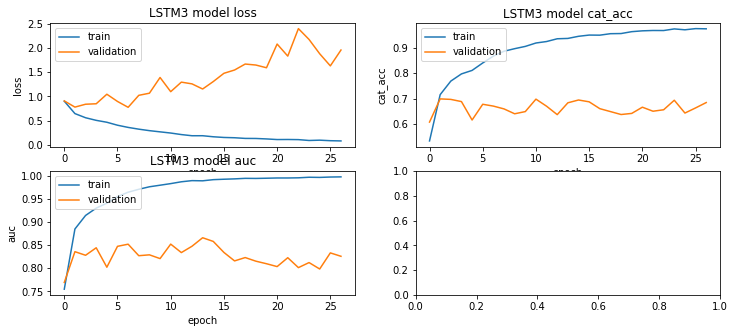

In [38]:
# model_LSTM2_1, history = createModel_LSTM2_1('LSTM2_1', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'LSTM3'
model[modelName], history[modelName] = createModel_LSTM3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [39]:
modelName = 'LSTM3'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

LSTM3 : 
66/66 [==============================] - 4s 61ms/step - loss: 0.7728 - cat_acc: 0.6705 - auc: 0.8521
[[333 223 140]
 [194 461  41]
 [ 68  22 606]]
Validation Score:  [0.7728047966957092, 0.6704980731010437, 0.8520640730857849]
Validation Prediction: 
 [[0.4880631  0.07346261 0.43847436]
 [0.5532486  0.08746175 0.35928965]
 [0.11113385 0.88528013 0.00358598]
 ...
 [0.23608613 0.04104069 0.7228732 ]
 [0.25069    0.04492725 0.7043827 ]
 [0.3143497  0.06115273 0.6244976 ]]


## LSTM4

In [ ]:
def createModel_LSTM4(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(LSTM(64,activation='tanh', return_sequences=True,name='LSTM1'))
    model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM2'))
    model.add(Dropout(0.2))


    model.add(LSTM(64,activation='tanh', return_sequences=True,name='LSTM11'))
    model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM12'))
    model.add(Dropout(0.2))

    model.add(LSTM(64,activation='tanh', return_sequences=True,name='LSTM21'))
    model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM22'))
    model.add(Dropout(0.2))

    model.add(LSTM(16,activation='tanh', return_sequences=False,name='LSTM3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 180, 64)           54528     
                                                                 
 LSTM2 (LSTM)                (None, 180, 32)           12416     
                                                                 
 dropout (Dropout)           (None, 180, 32)           0         
                                                                 
 LSTM11 (LSTM)               (None, 180, 64)           24832     
                                                                 
 LSTM12 (LSTM)               (None, 180, 32)           12416     
                                                                 
 dropout_1 (Dropout)         (None, 180, 32)           0         
        

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/LSTM4.ckpt/assets


162/162 [==============================] - 158s 888ms/step - loss: 1.0689 - cat_acc: 0.4144 - auc: 0.6022 - val_loss: 1.1238 - val_cat_acc: 0.3467 - val_auc: 0.5136
Epoch 2/100
162/162 [==============================] - 108s 664ms/step - loss: 0.9902 - cat_acc: 0.5009 - auc: 0.6947 - val_loss: 1.1753 - val_cat_acc: 0.3482 - val_auc: 0.5402
Epoch 3/100
162/162 [==============================] - 105s 649ms/step - loss: 0.9131 - cat_acc: 0.5552 - auc: 0.7532 - val_loss: 1.1950 - val_cat_acc: 0.3898 - val_auc: 0.5627
Epoch 4/100
162/162 [==============================] - 109s 671ms/step - loss: 0.8353 - cat_acc: 0.6038 - auc: 0.8006 - val_loss: 1.3199 - val_cat_acc: 0.3458 - val_auc: 0.5393
Epoch 5/100
162/162 [==============================] - 110s 681ms/step - loss: 0.7748 - cat_acc: 0.6384 - auc: 0.8323 - val_loss: 1.4058 - val_cat_acc: 0.3386 - val_auc: 0.4829
Epoch 6/100
162/162 [==============================] - 111s 689ms/step - loss: 0.7334 - cat_acc: 0.6789 - auc: 0.8507 - val_los

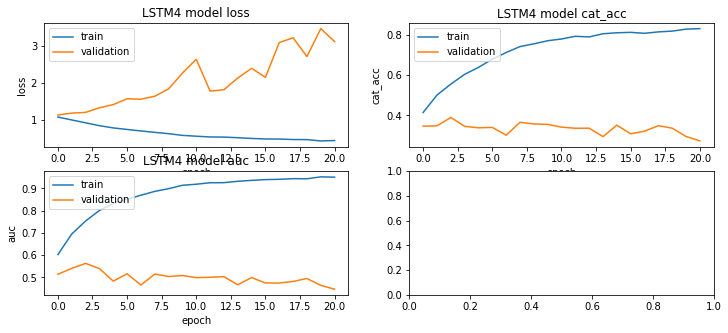

In [ ]:
# model_LSTM2_1, history = createModel_LSTM2_1('LSTM2_1', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'LSTM4'
model[modelName], history[modelName] = createModel_LSTM4(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'LSTM4'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

## ESN

In [ ]:
def createModel_ESN(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(Dropout(0.1))
    model.add(ESN(64,activation='tanh', return_sequences	=False, name='ESN1'))

    # model.add(LSTM(64,activation='tanh', dropout=0.1, return_sequences=True,name='LSTM1'))
    # model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM2'))
    # model.add(LSTM(16,activation='tanh', return_sequences=False,name='LSTM3'))
    model.add(Flatten())

    # model.add(Dropout(0.2))
    # model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    # model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    # model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    # model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 180, 96)           0         
                                                                 
 ESN1 (ESN)                  (None, 64)                10304     
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 head (Dense)                (None, 3)                 195       
                                                                 
Total params: 10,499
Trainable params: 195
Non-trainable params: 10,304
__

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 10s 61ms/step - loss: 1.2272 - cat_acc: 0.3986 - auc: 0.5743 - val_loss: 1.2930 - val_cat_acc: 0.4250 - val_auc: 0.6325
Epoch 2/100
145/146 [============================>.] - ETA: 0s - loss: 0.9452 - cat_acc: 0.5513 - auc: 0.7381

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 53ms/step - loss: 0.9456 - cat_acc: 0.5505 - auc: 0.7378 - val_loss: 1.1323 - val_cat_acc: 0.4825 - val_auc: 0.6881
Epoch 3/100
145/146 [============================>.] - ETA: 0s - loss: 0.8360 - cat_acc: 0.6142 - auc: 0.7999

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 53ms/step - loss: 0.8368 - cat_acc: 0.6143 - auc: 0.7996 - val_loss: 0.9974 - val_cat_acc: 0.5644 - val_auc: 0.7330
Epoch 4/100
145/146 [============================>.] - ETA: 0s - loss: 0.7861 - cat_acc: 0.6384 - auc: 0.8246

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 54ms/step - loss: 0.7860 - cat_acc: 0.6383 - auc: 0.8247 - val_loss: 0.9343 - val_cat_acc: 0.5712 - val_auc: 0.7583
Epoch 5/100
145/146 [============================>.] - ETA: 0s - loss: 0.7549 - cat_acc: 0.6694 - auc: 0.8415

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 54ms/step - loss: 0.7551 - cat_acc: 0.6690 - auc: 0.8414 - val_loss: 0.9095 - val_cat_acc: 0.5801 - val_auc: 0.7680
Epoch 6/100
145/146 [============================>.] - ETA: 0s - loss: 0.7422 - cat_acc: 0.6679 - auc: 0.8449

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 54ms/step - loss: 0.7422 - cat_acc: 0.6677 - auc: 0.8449 - val_loss: 0.8579 - val_cat_acc: 0.6041 - val_auc: 0.7902
Epoch 7/100
145/146 [============================>.] - ETA: 0s - loss: 0.7342 - cat_acc: 0.6672 - auc: 0.8488

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 53ms/step - loss: 0.7345 - cat_acc: 0.6671 - auc: 0.8486 - val_loss: 0.8303 - val_cat_acc: 0.6354 - val_auc: 0.8029
Epoch 8/100
145/146 [============================>.] - ETA: 0s - loss: 0.7266 - cat_acc: 0.6707 - auc: 0.8525

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 9s 60ms/step - loss: 0.7266 - cat_acc: 0.6710 - auc: 0.8525 - val_loss: 0.7977 - val_cat_acc: 0.6379 - val_auc: 0.8206
Epoch 9/100
146/146 [==============================] - 6s 43ms/step - loss: 0.7210 - cat_acc: 0.6798 - auc: 0.8547 - val_loss: 0.8023 - val_cat_acc: 0.6375 - val_auc: 0.8177
Epoch 10/100
145/146 [============================>.] - ETA: 0s - loss: 0.7169 - cat_acc: 0.6774 - auc: 0.8562

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 9s 59ms/step - loss: 0.7169 - cat_acc: 0.6774 - auc: 0.8562 - val_loss: 0.7785 - val_cat_acc: 0.6481 - val_auc: 0.8314
Epoch 11/100
145/146 [============================>.] - ETA: 0s - loss: 0.7075 - cat_acc: 0.6772 - auc: 0.8593

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 54ms/step - loss: 0.7097 - cat_acc: 0.6759 - auc: 0.8584 - val_loss: 0.7771 - val_cat_acc: 0.6417 - val_auc: 0.8313
Epoch 12/100
145/146 [============================>.] - ETA: 0s - loss: 0.7101 - cat_acc: 0.6866 - auc: 0.8584

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 9s 61ms/step - loss: 0.7097 - cat_acc: 0.6864 - auc: 0.8585 - val_loss: 0.7755 - val_cat_acc: 0.6569 - val_auc: 0.8322
Epoch 13/100
145/146 [============================>.] - ETA: 0s - loss: 0.7037 - cat_acc: 0.6860 - auc: 0.8610

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 57ms/step - loss: 0.7043 - cat_acc: 0.6860 - auc: 0.8607 - val_loss: 0.7747 - val_cat_acc: 0.6312 - val_auc: 0.8324
Epoch 14/100
145/146 [============================>.] - ETA: 0s - loss: 0.7033 - cat_acc: 0.6810 - auc: 0.8608

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 55ms/step - loss: 0.7029 - cat_acc: 0.6813 - auc: 0.8609 - val_loss: 0.7665 - val_cat_acc: 0.6692 - val_auc: 0.8366
Epoch 15/100
146/146 [==============================] - 6s 43ms/step - loss: 0.6972 - cat_acc: 0.6901 - auc: 0.8634 - val_loss: 0.7687 - val_cat_acc: 0.6544 - val_auc: 0.8354
Epoch 16/100
146/146 [==============================] - 6s 42ms/step - loss: 0.7091 - cat_acc: 0.6838 - auc: 0.8590 - val_loss: 0.7724 - val_cat_acc: 0.6455 - val_auc: 0.8335
Epoch 17/100
145/146 [============================>.] - ETA: 0s - loss: 0.7104 - cat_acc: 0.6756 - auc: 0.8584

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 9s 59ms/step - loss: 0.7104 - cat_acc: 0.6759 - auc: 0.8584 - val_loss: 0.7493 - val_cat_acc: 0.6612 - val_auc: 0.8469
Epoch 18/100
146/146 [==============================] - 6s 42ms/step - loss: 0.6967 - cat_acc: 0.6787 - auc: 0.8634 - val_loss: 0.7510 - val_cat_acc: 0.6582 - val_auc: 0.8452
Epoch 19/100
145/146 [============================>.] - ETA: 0s - loss: 0.7030 - cat_acc: 0.6864 - auc: 0.8610

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 8s 55ms/step - loss: 0.7048 - cat_acc: 0.6862 - auc: 0.8606 - val_loss: 0.7367 - val_cat_acc: 0.6692 - val_auc: 0.8531
Epoch 20/100
146/146 [==============================] - 6s 43ms/step - loss: 0.6998 - cat_acc: 0.6841 - auc: 0.8633 - val_loss: 0.7414 - val_cat_acc: 0.6696 - val_auc: 0.8501
Epoch 21/100
146/146 [==============================] - 6s 43ms/step - loss: 0.7004 - cat_acc: 0.6862 - auc: 0.8631 - val_loss: 0.7455 - val_cat_acc: 0.6612 - val_auc: 0.8470
Epoch 22/100
146/146 [==============================] - 6s 43ms/step - loss: 0.7078 - cat_acc: 0.6783 - auc: 0.8595 - val_loss: 0.7481 - val_cat_acc: 0.6515 - val_auc: 0.8456
Epoch 23/100
146/146 [==============================] - ETA: 0s - loss: 0.6985 - cat_acc: 0.6866 - auc: 0.8623

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN.ckpt/assets


146/146 [==============================] - 9s 59ms/step - loss: 0.6985 - cat_acc: 0.6866 - auc: 0.8623 - val_loss: 0.7319 - val_cat_acc: 0.6658 - val_auc: 0.8538
Epoch 24/100
146/146 [==============================] - 6s 43ms/step - loss: 0.6939 - cat_acc: 0.6875 - auc: 0.8653 - val_loss: 0.7527 - val_cat_acc: 0.6612 - val_auc: 0.8428
Epoch 25/100
146/146 [==============================] - 6s 43ms/step - loss: 0.6967 - cat_acc: 0.6926 - auc: 0.8635 - val_loss: 0.7462 - val_cat_acc: 0.6827 - val_auc: 0.8461
Epoch 26/100
146/146 [==============================] - 6s 42ms/step - loss: 0.7037 - cat_acc: 0.6875 - auc: 0.8616 - val_loss: 0.7512 - val_cat_acc: 0.6726 - val_auc: 0.8435
Epoch 27/100
146/146 [==============================] - 7s 46ms/step - loss: 0.6924 - cat_acc: 0.6866 - auc: 0.8653 - val_loss: 0.7402 - val_cat_acc: 0.6650 - val_auc: 0.8495
Epoch 28/100
146/146 [==============================] - 6s 42ms/step - loss: 0.7049 - cat_acc: 0.6836 - auc: 0.8610 - val_loss: 0.7501 - v

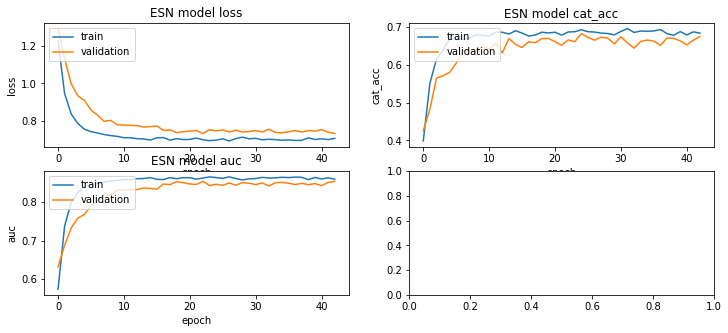

In [ ]:
# model_ESN, history = createModel_ESN('ESN', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'ESN'
model[modelName], history[modelName] = createModel_ESN(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'ESN'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

ESN : 
74/74 [==============================] - 5s 63ms/step - loss: 0.7319 - cat_acc: 0.6658 - auc: 0.8538
[[496 249  44]
 [178 350 261]
 [ 15  44 730]]
Validation Score:  [0.7319470643997192, 0.6658217310905457, 0.8537771701812744]
Validation Prediction: 
 [[0.5145944  0.34971434 0.13569127]
 [0.4305244  0.48123077 0.08824485]
 [0.32589197 0.4501442  0.22396386]
 ...
 [0.03994749 0.10682493 0.8532276 ]
 [0.01715805 0.05585187 0.92699015]
 [0.06124261 0.10603235 0.83272505]]


## ESN2 (more ESN layer)

In [ ]:
def createModel_ESN2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(Dropout(0.1))
    model.add(ESN(128,activation='tanh', return_sequences	=True, name='ESN1'))
    model.add(ESN(64,activation='tanh', return_sequences	=True, name='ESN2'))
    model.add(ESN(32,activation='tanh', return_sequences	=False, name='ESN3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 180, 148)          0         
                                                                 
 ESN1 (ESN)                  (None, 180, 128)          35456     
                                                                 
 ESN2 (ESN)                  (None, 180, 64)           12352     
                                                                 
 ESN3 (ESN)                  (None, 32)                3104      
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
      

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 24s 135ms/step - loss: 0.9948 - cat_acc: 0.5212 - auc: 0.7093 - val_loss: 0.9186 - val_cat_acc: 0.5148 - val_auc: 0.7776
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.8860 - cat_acc: 0.5769 - auc: 0.7743

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 122ms/step - loss: 0.8860 - cat_acc: 0.5769 - auc: 0.7743 - val_loss: 0.8377 - val_cat_acc: 0.5512 - val_auc: 0.7976
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.8361 - cat_acc: 0.6109 - auc: 0.8027

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 126ms/step - loss: 0.8361 - cat_acc: 0.6109 - auc: 0.8027 - val_loss: 0.8128 - val_cat_acc: 0.5905 - val_auc: 0.8087
Epoch 4/100
162/162 [==============================] - ETA: 0s - loss: 0.8287 - cat_acc: 0.6013 - auc: 0.8054

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 123ms/step - loss: 0.8287 - cat_acc: 0.6013 - auc: 0.8054 - val_loss: 0.8028 - val_cat_acc: 0.6216 - val_auc: 0.8177
Epoch 5/100
162/162 [==============================] - 16s 98ms/step - loss: 0.8066 - cat_acc: 0.6061 - auc: 0.8141 - val_loss: 0.8136 - val_cat_acc: 0.5900 - val_auc: 0.8068
Epoch 6/100
162/162 [==============================] - ETA: 0s - loss: 0.7986 - cat_acc: 0.6197 - auc: 0.8204

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 126ms/step - loss: 0.7986 - cat_acc: 0.6197 - auc: 0.8204 - val_loss: 0.7763 - val_cat_acc: 0.6274 - val_auc: 0.8259
Epoch 7/100
162/162 [==============================] - ETA: 0s - loss: 0.7903 - cat_acc: 0.6413 - auc: 0.8245

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 124ms/step - loss: 0.7903 - cat_acc: 0.6413 - auc: 0.8245 - val_loss: 0.7697 - val_cat_acc: 0.6125 - val_auc: 0.8333
Epoch 8/100
162/162 [==============================] - ETA: 0s - loss: 0.7746 - cat_acc: 0.6533 - auc: 0.8321

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 122ms/step - loss: 0.7746 - cat_acc: 0.6533 - auc: 0.8321 - val_loss: 0.7656 - val_cat_acc: 0.6365 - val_auc: 0.8338
Epoch 9/100
162/162 [==============================] - ETA: 0s - loss: 0.7751 - cat_acc: 0.6537 - auc: 0.8310

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 126ms/step - loss: 0.7751 - cat_acc: 0.6537 - auc: 0.8310 - val_loss: 0.7644 - val_cat_acc: 0.6422 - val_auc: 0.8337
Epoch 10/100
162/162 [==============================] - 16s 99ms/step - loss: 0.7684 - cat_acc: 0.6576 - auc: 0.8339 - val_loss: 0.7795 - val_cat_acc: 0.6049 - val_auc: 0.8225
Epoch 11/100
162/162 [==============================] - 16s 98ms/step - loss: 0.7652 - cat_acc: 0.6556 - auc: 0.8359 - val_loss: 0.8006 - val_cat_acc: 0.6078 - val_auc: 0.8119
Epoch 12/100
162/162 [==============================] - 16s 100ms/step - loss: 0.7631 - cat_acc: 0.6640 - auc: 0.8379 - val_loss: 0.7736 - val_cat_acc: 0.6164 - val_auc: 0.8239
Epoch 13/100
162/162 [==============================] - ETA: 0s - loss: 0.7526 - cat_acc: 0.6674 - auc: 0.8418

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 122ms/step - loss: 0.7526 - cat_acc: 0.6674 - auc: 0.8418 - val_loss: 0.7636 - val_cat_acc: 0.6327 - val_auc: 0.8337
Epoch 14/100
162/162 [==============================] - 16s 100ms/step - loss: 0.7448 - cat_acc: 0.6798 - auc: 0.8465 - val_loss: 0.7780 - val_cat_acc: 0.6317 - val_auc: 0.8260
Epoch 15/100
162/162 [==============================] - 16s 99ms/step - loss: 0.7558 - cat_acc: 0.6661 - auc: 0.8408 - val_loss: 0.7685 - val_cat_acc: 0.6499 - val_auc: 0.8327
Epoch 16/100
162/162 [==============================] - ETA: 0s - loss: 0.7360 - cat_acc: 0.6744 - auc: 0.8491

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN2.ckpt/assets


162/162 [==============================] - 20s 123ms/step - loss: 0.7360 - cat_acc: 0.6744 - auc: 0.8491 - val_loss: 0.7581 - val_cat_acc: 0.6600 - val_auc: 0.8358
Epoch 17/100
162/162 [==============================] - 16s 99ms/step - loss: 0.7465 - cat_acc: 0.6723 - auc: 0.8454 - val_loss: 0.7854 - val_cat_acc: 0.6513 - val_auc: 0.8242
Epoch 18/100
162/162 [==============================] - 16s 98ms/step - loss: 0.7462 - cat_acc: 0.6727 - auc: 0.8455 - val_loss: 0.7838 - val_cat_acc: 0.6116 - val_auc: 0.8225
Epoch 19/100
162/162 [==============================] - 16s 98ms/step - loss: 0.7319 - cat_acc: 0.6837 - auc: 0.8531 - val_loss: 0.7887 - val_cat_acc: 0.6111 - val_auc: 0.8224
Epoch 20/100
162/162 [==============================] - 16s 97ms/step - loss: 0.7268 - cat_acc: 0.6814 - auc: 0.8538 - val_loss: 0.7920 - val_cat_acc: 0.6298 - val_auc: 0.8206
Epoch 21/100
162/162 [==============================] - 16s 98ms/step - loss: 0.7296 - cat_acc: 0.6843 - auc: 0.8535 - val_loss: 0.7

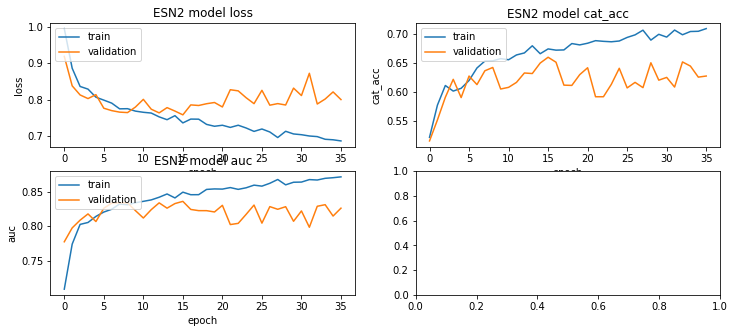

In [ ]:
modelName = 'ESN2'
model[modelName], history[modelName] = createModel_ESN2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'ESN2'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

ESN2 : 
66/66 [==============================] - 4s 66ms/step - loss: 0.7581 - cat_acc: 0.6600 - auc: 0.8358
[[376 186 134]
 [217 448  31]
 [ 34 108 554]]
Validation Score:  [0.7581458687782288, 0.6599617004394531, 0.8358489274978638]
Validation Prediction: 
 [[0.16720663 0.11224058 0.7205528 ]
 [0.22933128 0.17056678 0.60010195]
 [0.39573857 0.5569429  0.04731852]
 ...
 [0.06829122 0.07472543 0.85698336]
 [0.09066401 0.06679396 0.84254205]
 [0.12277026 0.21961221 0.65761745]]


## ESN3 (more Dense layer)

In [ ]:
def createModel_ESN3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(Dropout(0.1))
    model.add(ESN(400,activation='tanh',leaky=0.9, return_sequences	=True,  name='ESN1'))
    # model.add(ESN(32,activation='tanh', return_sequences	=True,  name='ESN2'))
    model.add(ESN(100,activation='tanh',leaky=0.9, return_sequences	=False, name='ESN3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 180, 148)          0         
                                                                 
 ESN1 (ESN)                  (None, 180, 400)          219600    
                                                                 
 ESN3 (ESN)                  (None, 100)               50100     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 Dense0 (Dense)              (None, 128)               12928     
        

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN3.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN3.ckpt/assets


162/162 [==============================] - 58s 349ms/step - loss: 0.8615 - cat_acc: 0.6007 - auc: 0.7861 - val_loss: 0.8479 - val_cat_acc: 0.6868 - val_auc: 0.8376
Epoch 2/100
162/162 [==============================] - 52s 319ms/step - loss: 0.7322 - cat_acc: 0.6798 - auc: 0.8555 - val_loss: 1.0502 - val_cat_acc: 0.5369 - val_auc: 0.7388
Epoch 3/100
162/162 [==============================] - 51s 313ms/step - loss: 0.6808 - cat_acc: 0.7015 - auc: 0.8723 - val_loss: 1.4745 - val_cat_acc: 0.4363 - val_auc: 0.6836
Epoch 4/100
162/162 [==============================] - 52s 319ms/step - loss: 0.6392 - cat_acc: 0.7363 - auc: 0.8890 - val_loss: 0.8595 - val_cat_acc: 0.5891 - val_auc: 0.7953
Epoch 5/100
162/162 [==============================] - ETA: 0s - loss: 0.6187 - cat_acc: 0.7483 - auc: 0.8957

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN3.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN3.ckpt/assets


162/162 [==============================] - 56s 345ms/step - loss: 0.6187 - cat_acc: 0.7483 - auc: 0.8957 - val_loss: 0.7365 - val_cat_acc: 0.6633 - val_auc: 0.8441
Epoch 6/100
162/162 [==============================] - 53s 326ms/step - loss: 0.5914 - cat_acc: 0.7648 - auc: 0.9049 - val_loss: 1.0293 - val_cat_acc: 0.5503 - val_auc: 0.7533
Epoch 7/100
162/162 [==============================] - 55s 338ms/step - loss: 0.5694 - cat_acc: 0.7700 - auc: 0.9107 - val_loss: 1.4530 - val_cat_acc: 0.4780 - val_auc: 0.7004
Epoch 8/100
162/162 [==============================] - 67s 412ms/step - loss: 0.5748 - cat_acc: 0.7640 - auc: 0.9088 - val_loss: 1.4031 - val_cat_acc: 0.4626 - val_auc: 0.7091
Epoch 9/100
162/162 [==============================] - 52s 325ms/step - loss: 0.5558 - cat_acc: 0.7719 - auc: 0.9151 - val_loss: 1.9540 - val_cat_acc: 0.4583 - val_auc: 0.6627
Epoch 10/100
162/162 [==============================] - 53s 329ms/step - loss: 0.5483 - cat_acc: 0.7820 - auc: 0.9170 - val_loss: 1.

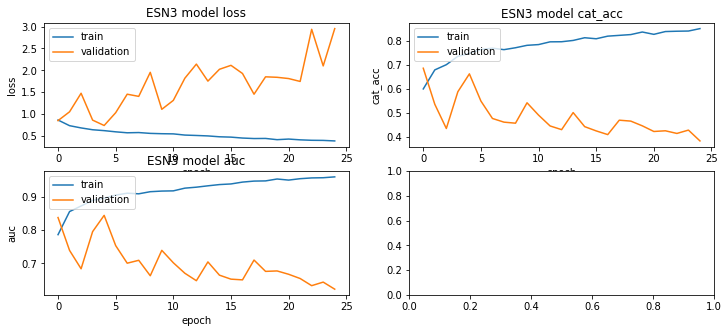

In [ ]:
modelName = 'ESN3'
model[modelName], history[modelName] = createModel_ESN3(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'ESN3'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

ESN3 : 
66/66 [==============================] - 15s 232ms/step - loss: 0.7365 - cat_acc: 0.6633 - auc: 0.8441
[[156 328 212]
 [ 20 565 111]
 [  0  32 664]]
Validation Score:  [0.7364946603775024, 0.663314163684845, 0.8441147208213806]
Validation Prediction: 
 [[2.4525137e-01 1.7508154e-01 5.7966709e-01]
 [2.3864134e-01 1.5857126e-01 6.0278738e-01]
 [3.0146265e-01 5.6788939e-01 1.3064788e-01]
 ...
 [2.4369467e-02 8.3995337e-04 9.7479057e-01]
 [2.9481396e-02 1.2562136e-03 9.6926236e-01]
 [3.5747781e-02 1.8869620e-03 9.6236527e-01]]


## ESN5 (more ESN and Dense layer)

In [ ]:
def createModel_ESN5(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)
    model.add(Dropout(0.1))
    model.add(ESN(64,activation='tanh',leaky=0.9, return_sequences	=True,  name='ESN1'))
    model.add(ESN(32,activation='tanh',leaky=0.9, return_sequences	=True,  name='ESN2'))

    model.add(Dropout(0.2))
    model.add(ESN(64,activation='tanh',leaky=0.9, return_sequences	=True,  name='ESN11'))
    model.add(ESN(32,activation='tanh',leaky=0.9, return_sequences	=True,  name='ESN21'))
    model.add(ESN(16,activation='tanh',leaky=0.9, return_sequences	=False, name='ESN3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 180, 148)          0         
                                                                 
 ESN1 (ESN)                  (None, 180, 64)           13632     
                                                                 
 ESN2 (ESN)                  (None, 180, 32)           3104      
                                                                 
 dropout_19 (Dropout)        (None, 180, 32)           0         
                                                                 
 ESN11 (ESN)                 (None, 180, 64)           6208      
                                                                 
 ESN21 (ESN)                 (None, 180, 32)           3104      
      

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


162/162 [==============================] - 62s 374ms/step - loss: 1.0251 - cat_acc: 0.4676 - auc: 0.6594 - val_loss: 0.9389 - val_cat_acc: 0.4943 - val_auc: 0.7383
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.9353 - cat_acc: 0.5318 - auc: 0.7353

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


162/162 [==============================] - 21s 133ms/step - loss: 0.9353 - cat_acc: 0.5318 - auc: 0.7353 - val_loss: 0.9018 - val_cat_acc: 0.4995 - val_auc: 0.7586
Epoch 3/100
162/162 [==============================] - 16s 98ms/step - loss: 0.9288 - cat_acc: 0.5370 - auc: 0.7410 - val_loss: 0.9551 - val_cat_acc: 0.5115 - val_auc: 0.7403
Epoch 4/100
162/162 [==============================] - 16s 99ms/step - loss: 0.9191 - cat_acc: 0.5403 - auc: 0.7470 - val_loss: 0.9303 - val_cat_acc: 0.5450 - val_auc: 0.7452
Epoch 5/100
162/162 [==============================] - ETA: 0s - loss: 0.9170 - cat_acc: 0.5454 - auc: 0.7507

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN5.ckpt/assets


162/162 [==============================] - 27s 169ms/step - loss: 0.9170 - cat_acc: 0.5454 - auc: 0.7507 - val_loss: 0.8757 - val_cat_acc: 0.5244 - val_auc: 0.7685
Epoch 6/100
162/162 [==============================] - 16s 98ms/step - loss: 0.9274 - cat_acc: 0.5450 - auc: 0.7440 - val_loss: 0.9186 - val_cat_acc: 0.5105 - val_auc: 0.7485
Epoch 7/100
162/162 [==============================] - 16s 102ms/step - loss: 0.9185 - cat_acc: 0.5490 - auc: 0.7506 - val_loss: 0.8867 - val_cat_acc: 0.5364 - val_auc: 0.7636
Epoch 8/100
162/162 [==============================] - 16s 99ms/step - loss: 0.9196 - cat_acc: 0.5545 - auc: 0.7502 - val_loss: 0.9211 - val_cat_acc: 0.5359 - val_auc: 0.7473
Epoch 9/100
162/162 [==============================] - 16s 98ms/step - loss: 0.9083 - cat_acc: 0.5585 - auc: 0.7581 - val_loss: 0.9133 - val_cat_acc: 0.5206 - val_auc: 0.7506
Epoch 10/100
162/162 [==============================] - 16s 98ms/step - loss: 0.9049 - cat_acc: 0.5614 - auc: 0.7595 - val_loss: 0.8995

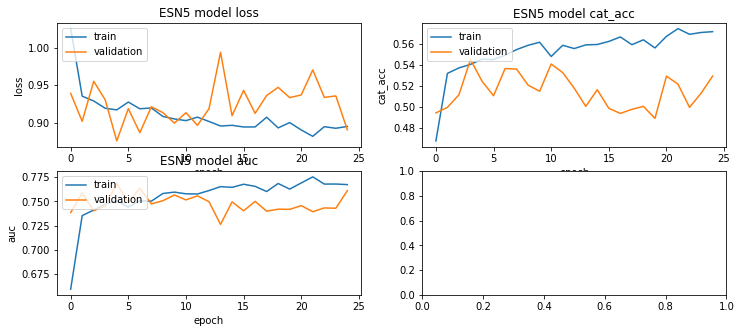

In [ ]:
modelName = 'ESN5'
model[modelName], history[modelName] = createModel_ESN5(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'ESN5'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

ESN5 : 
66/66 [==============================] - 4s 64ms/step - loss: 0.8757 - cat_acc: 0.5244 - auc: 0.7685
[[348 143 205]
 [397 133 166]
 [ 51  31 614]]
Validation Score:  [0.8757019639015198, 0.5244252681732178, 0.7685205936431885]
Validation Prediction: 
 [[0.11878655 0.13093247 0.750281  ]
 [0.41102794 0.47356686 0.11540515]
 [0.43394616 0.45368236 0.11237144]
 ...
 [0.11912175 0.17447793 0.7064003 ]
 [0.11069004 0.14795063 0.7413593 ]
 [0.10876466 0.14353389 0.74770147]]


## ESN4 (combine with other layer)

In [ ]:
def createModel_ESN4(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(ESN(128,activation='tanh', return_sequences	=True,  name='ESN1'))
    model.add(Dropout(0.2))

    model.add(LSTM(64,activation='tanh', return_sequences=True,name='LSTM1'))
    model.add(LSTM(32,activation='tanh', return_sequences=True,name='LSTM2'))
    model.add(LSTM(16,activation='tanh', return_sequences=False,name='LSTM3'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=0.0001),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ESN1 (ESN)                  (None, 180, 128)          28800     
                                                                 
 dropout_37 (Dropout)        (None, 180, 128)          0         
                                                                 
 LSTM1 (LSTM)                (None, 180, 64)           49408     
                                                                 
 LSTM2 (LSTM)                (None, 180, 32)           12416     
                                                                 
 LSTM3 (LSTM)                (None, 16)                3136      
                                                                 
 flatten_18 (Flatten)        (None, 16)                0         
       

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


146/146 [==============================] - 50s 304ms/step - loss: 1.0887 - cat_acc: 0.3511 - auc: 0.5682 - val_loss: 1.0920 - val_cat_acc: 0.3392 - val_auc: 0.5532
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 1.0512 - cat_acc: 0.4452 - auc: 0.6395

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


146/146 [==============================] - 42s 288ms/step - loss: 1.0512 - cat_acc: 0.4452 - auc: 0.6395 - val_loss: 1.0832 - val_cat_acc: 0.3587 - val_auc: 0.5688
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 0.9964 - cat_acc: 0.5458 - auc: 0.7068

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


146/146 [==============================] - 41s 282ms/step - loss: 0.9964 - cat_acc: 0.5458 - auc: 0.7068 - val_loss: 1.0748 - val_cat_acc: 0.4170 - val_auc: 0.5852
Epoch 4/100
146/146 [==============================] - ETA: 0s - loss: 0.9475 - cat_acc: 0.5765 - auc: 0.7459

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


146/146 [==============================] - 43s 296ms/step - loss: 0.9475 - cat_acc: 0.5765 - auc: 0.7459 - val_loss: 1.0608 - val_cat_acc: 0.4635 - val_auc: 0.6169
Epoch 5/100
146/146 [==============================] - 25s 169ms/step - loss: 0.8984 - cat_acc: 0.5915 - auc: 0.7683 - val_loss: 1.0715 - val_cat_acc: 0.4542 - val_auc: 0.6164
Epoch 6/100
146/146 [==============================] - ETA: 0s - loss: 0.8433 - cat_acc: 0.6106 - auc: 0.7963

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/ESN4.ckpt/assets


146/146 [==============================] - 42s 286ms/step - loss: 0.8433 - cat_acc: 0.6106 - auc: 0.7963 - val_loss: 1.0514 - val_cat_acc: 0.4736 - val_auc: 0.6421
Epoch 7/100
146/146 [==============================] - 25s 169ms/step - loss: 0.8151 - cat_acc: 0.6197 - auc: 0.8066 - val_loss: 1.1369 - val_cat_acc: 0.4208 - val_auc: 0.6007
Epoch 8/100
146/146 [==============================] - 25s 169ms/step - loss: 0.7900 - cat_acc: 0.6330 - auc: 0.8178 - val_loss: 1.0706 - val_cat_acc: 0.4520 - val_auc: 0.6304
Epoch 9/100
146/146 [==============================] - 25s 169ms/step - loss: 0.7706 - cat_acc: 0.6394 - auc: 0.8261 - val_loss: 1.1838 - val_cat_acc: 0.3954 - val_auc: 0.5883
Epoch 10/100
146/146 [==============================] - 25s 169ms/step - loss: 0.7468 - cat_acc: 0.6600 - auc: 0.8372 - val_loss: 1.1449 - val_cat_acc: 0.4335 - val_auc: 0.6112
Epoch 11/100
146/146 [==============================] - 25s 169ms/step - loss: 0.7489 - cat_acc: 0.6609 - auc: 0.8369 - val_loss: 1

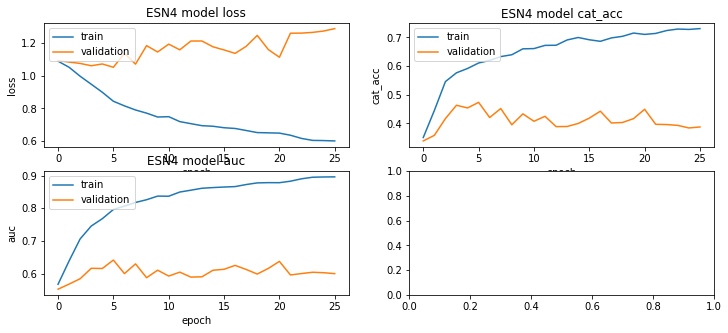

In [ ]:
modelName = 'ESN4'
model[modelName], history[modelName] = createModel_ESN4(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'ESN4'
print(modelName,'- Combining ESN and LSTM3: ')
showResult(model[modelName], X_val_ts,y_val_ts)

ESN4 - Combining ESN and LSTM3: 
74/74 [==============================] - 6s 75ms/step - loss: 1.0514 - cat_acc: 0.4736 - auc: 0.6421
[[563 207  19]
 [422 280  87]
 [289 222 278]]
Validation Score:  [1.051411747932434, 0.4735952615737915, 0.6421017646789551]
Validation Prediction: 
 [[0.3594048  0.41367236 0.22692282]
 [0.38272482 0.42089397 0.19638118]
 [0.41138816 0.42443982 0.16417201]
 ...
 [0.27266744 0.33217472 0.39515787]
 [0.27481088 0.3343768  0.3908123 ]
 [0.2798778  0.33949608 0.38062614]]


## Deep NN (Dense)

In [ ]:
def createModel_DNN(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=150):
  print('X_train.shape: ',X_train_ts.shape)
  print('y_train.shape: ',y_train_ts.shape)
  print('X_val.shape: ',X_val_ts.shape)
  print('y_val.shape: ',y_val_ts.shape)

  filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
  look_back = X_train_ts.shape[1]
  n_feat = X_train_ts.shape[2]

  model = tf.keras.Sequential()
  model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
  model.add( Normalization(axis=None))
  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(layers.Dense(units = 32  , activation = 'sigmoid', name='Dense'))
  model.add(layers.Dense(units = 64  , activation = 'sigmoid', name='Dense0'))
  model.add(layers.Dense(units = 32  , activation = 'sigmoid', name='Dense1'))
  model.add(layers.Dense(units = 16  , activation = 'sigmoid', name='Dense2'))
  model.add(layers.Dense(units = 8  , activation = 'sigmoid', name='Dense3'))
  model.add(Dropout(0.2))
  model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

  METRICS = [
        metrics.CategoricalAccuracy(name='cat_acc'),
        metrics.AUC(name='auc'),
  ]

  model.compile(
          optimizer = keras.optimizers.Adam(learning_rate=1e-4),
          loss = 'categorical_crossentropy',
          metrics = METRICS
  )
  model.summary()

  es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=30, verbose=1, mode='auto', 
                          baseline=None, restore_best_weights=True)

  callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


  history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                    epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
  _=plotTrain( history, modelName, ['cat_acc','auc'])
  return model, history

X_train.shape:  (1863, 60, 49)
y_train.shape:  (1863, 3)
X_val.shape:  (738, 60, 49)
y_val.shape:  (738, 3)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 60, 49)           3         
 tion)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 2940)              0         
                                                                 
 dropout_10 (Dropout)        (None, 2940)              0         
                                                                 
 Dense (Dense)               (None, 32)                94112     
                                                                 
 Dense0 (Dense)              (None, 64)                2112      
                                                                 
 Dense1 (De

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 4s 44ms/step - loss: 1.2278 - cat_acc: 0.3398 - auc: 0.5001 - val_loss: 1.1660 - val_cat_acc: 0.3333 - val_auc: 0.5012
Epoch 2/150
55/59 [==========================>...] - ETA: 0s - loss: 1.2006 - cat_acc: 0.3278 - auc: 0.4957INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 3s 44ms/step - loss: 1.1981 - cat_acc: 0.3301 - auc: 0.4970 - val_loss: 1.1423 - val_cat_acc: 0.3333 - val_auc: 0.5009
Epoch 3/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1808 - cat_acc: 0.3325 - auc: 0.5018INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1770 - cat_acc: 0.3376 - auc: 0.5039 - val_loss: 1.1271 - val_cat_acc: 0.3333 - val_auc: 0.4945
Epoch 4/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1746 - cat_acc: 0.3284 - auc: 0.4895INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1728 - cat_acc: 0.3280 - auc: 0.4897 - val_loss: 1.1174 - val_cat_acc: 0.3333 - val_auc: 0.4999
Epoch 5/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1678 - cat_acc: 0.3184 - auc: 0.4930INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 37ms/step - loss: 1.1693 - cat_acc: 0.3188 - auc: 0.4913 - val_loss: 1.1108 - val_cat_acc: 0.3333 - val_auc: 0.4998
Epoch 6/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1606 - cat_acc: 0.3225 - auc: 0.4896INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 39ms/step - loss: 1.1583 - cat_acc: 0.3231 - auc: 0.4922 - val_loss: 1.1065 - val_cat_acc: 0.3333 - val_auc: 0.5021
Epoch 7/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1346 - cat_acc: 0.3561 - auc: 0.5167INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 37ms/step - loss: 1.1384 - cat_acc: 0.3516 - auc: 0.5122 - val_loss: 1.1044 - val_cat_acc: 0.3333 - val_auc: 0.5008
Epoch 8/150
54/59 [==========================>...] - ETA: 0s - loss: 1.1476 - cat_acc: 0.3235 - auc: 0.4982INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 3s 48ms/step - loss: 1.1472 - cat_acc: 0.3253 - auc: 0.4985 - val_loss: 1.1026 - val_cat_acc: 0.3333 - val_auc: 0.4992
Epoch 9/150
59/59 [==============================] - ETA: 0s - loss: 1.1253 - cat_acc: 0.3403 - auc: 0.5192INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1253 - cat_acc: 0.3403 - auc: 0.5192 - val_loss: 1.1014 - val_cat_acc: 0.3333 - val_auc: 0.4991
Epoch 10/150
57/59 [===========================>..] - ETA: 0s - loss: 1.1457 - cat_acc: 0.3196 - auc: 0.4994INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1464 - cat_acc: 0.3183 - auc: 0.4975 - val_loss: 1.1008 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 11/150
54/59 [==========================>...] - ETA: 0s - loss: 1.1340 - cat_acc: 0.3466 - auc: 0.5108INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 37ms/step - loss: 1.1358 - cat_acc: 0.3451 - auc: 0.5083 - val_loss: 1.1002 - val_cat_acc: 0.3333 - val_auc: 0.4949
Epoch 12/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1265 - cat_acc: 0.3508 - auc: 0.5194INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1250 - cat_acc: 0.3500 - auc: 0.5204 - val_loss: 1.0999 - val_cat_acc: 0.3333 - val_auc: 0.4998
Epoch 13/150
58/59 [============================>.] - ETA: 0s - loss: 1.1383 - cat_acc: 0.3254 - auc: 0.4954INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 39ms/step - loss: 1.1387 - cat_acc: 0.3253 - auc: 0.4950 - val_loss: 1.0997 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 14/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1441 - cat_acc: 0.3215 - auc: 0.4871 - val_loss: 1.0997 - val_cat_acc: 0.3333 - val_auc: 0.5003
Epoch 15/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1419 - cat_acc: 0.3331 - auc: 0.4963INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1409 - cat_acc: 0.3349 - auc: 0.4982 - val_loss: 1.0995 - val_cat_acc: 0.3333 - val_auc: 0.4998
Epoch 16/150
54/59 [==========================>...] - ETA: 0s - loss: 1.1287 - cat_acc: 0.3409 - auc: 0.5063INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 5s 81ms/step - loss: 1.1294 - cat_acc: 0.3398 - auc: 0.5056 - val_loss: 1.0993 - val_cat_acc: 0.3333 - val_auc: 0.4995
Epoch 17/150
54/59 [==========================>...] - ETA: 0s - loss: 1.1262 - cat_acc: 0.3385 - auc: 0.5102INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1262 - cat_acc: 0.3376 - auc: 0.5099 - val_loss: 1.0993 - val_cat_acc: 0.3333 - val_auc: 0.4998
Epoch 18/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1249 - cat_acc: 0.3384 - auc: 0.5111INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1274 - cat_acc: 0.3387 - auc: 0.5064 - val_loss: 1.0991 - val_cat_acc: 0.3333 - val_auc: 0.5012
Epoch 19/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1346 - cat_acc: 0.3129 - auc: 0.4948 - val_loss: 1.0993 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 20/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1227 - cat_acc: 0.3473 - auc: 0.5125 - val_loss: 1.0992 - val_cat_acc: 0.3333 - val_auc: 0.4990
Epoch 21/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1289 - cat_acc: 0.3339 - auc: 0.5049 - val_loss: 1.0992 - val_cat_acc: 0.3333 - val_auc: 0.5008
Epoch 22/150
59/59 [==============================] - ETA: 0s - loss: 1.1265 - cat_acc: 0.3280 - auc: 0.5046INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 39ms/step - loss: 1.1265 - cat_acc: 0.3280 - auc: 0.5046 - val_loss: 1.0991 - val_cat_acc: 0.3333 - val_auc: 0.4927
Epoch 23/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1210 - cat_acc: 0.3489 - auc: 0.5150 - val_loss: 1.0992 - val_cat_acc: 0.3333 - val_auc: 0.4944
Epoch 24/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1253 - cat_acc: 0.3462 - auc: 0.5106 - val_loss: 1.0991 - val_cat_acc: 0.3333 - val_auc: 0.5009
Epoch 25/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1234 - cat_acc: 0.3457 - auc: 0.5072 - val_loss: 1.0992 - val_cat_acc: 0.3333 - val_auc: 0.4977
Epoch 26/150
58/59 [============================>.] - ETA: 0s - loss: 1.1263 - cat_acc: 0.3297 - auc: 0.5031INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1263 - cat_acc: 0.3296 - auc: 0.5028 - val_loss: 1.0991 - val_cat_acc: 0.3333 - val_auc: 0.4965
Epoch 27/150
58/59 [============================>.] - ETA: 0s - loss: 1.1231 - cat_acc: 0.3292 - auc: 0.5060INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1233 - cat_acc: 0.3285 - auc: 0.5056 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 28/150
52/59 [=========================>....] - ETA: 0s - loss: 1.1280 - cat_acc: 0.3299 - auc: 0.4960INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 3s 46ms/step - loss: 1.1281 - cat_acc: 0.3296 - auc: 0.4957 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 29/150
52/59 [=========================>....] - ETA: 0s - loss: 1.1176 - cat_acc: 0.3431 - auc: 0.5110INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 37ms/step - loss: 1.1177 - cat_acc: 0.3414 - auc: 0.5114 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.4997
Epoch 30/150
59/59 [==============================] - 1s 8ms/step - loss: 1.1196 - cat_acc: 0.3430 - auc: 0.5059 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.4992
Epoch 31/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1251 - cat_acc: 0.3339 - auc: 0.4988 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 32/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1177 - cat_acc: 0.3387 - auc: 0.5127 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.4999
Epoch 33/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1157 - cat_acc: 0.3366 - auc: 0.5092 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.4999
Epoch 34/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1155 - cat_acc: 0.3564 - auc: 0.5163 - val_loss: 1.0990 - val_cat_acc: 0.333

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 39ms/step - loss: 1.1152 - cat_acc: 0.3382 - auc: 0.5124 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4974
Epoch 37/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1224 - cat_acc: 0.3403 - auc: 0.4981 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4988
Epoch 38/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1184 - cat_acc: 0.3402 - auc: 0.5027INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1190 - cat_acc: 0.3360 - auc: 0.4997 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.5006
Epoch 39/150
53/59 [=========================>....] - ETA: 0s - loss: 1.1246 - cat_acc: 0.3290 - auc: 0.4840INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 37ms/step - loss: 1.1232 - cat_acc: 0.3269 - auc: 0.4838 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4929
Epoch 40/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1222 - cat_acc: 0.3199 - auc: 0.4928 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4999
Epoch 41/150
59/59 [==============================] - ETA: 0s - loss: 1.1243 - cat_acc: 0.3247 - auc: 0.4861INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1243 - cat_acc: 0.3247 - auc: 0.4861 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4975
Epoch 42/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1232 - cat_acc: 0.3242 - auc: 0.4874 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.5008
Epoch 43/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1234 - cat_acc: 0.3172 - auc: 0.4921 - val_loss: 1.0990 - val_cat_acc: 0.3333 - val_auc: 0.4997
Epoch 44/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1117 - cat_acc: 0.3484 - auc: 0.5143 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4995
Epoch 45/150
52/59 [=========================>....] - ETA: 0s - loss: 1.1140 - cat_acc: 0.3425 - auc: 0.5068INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 3s 44ms/step - loss: 1.1139 - cat_acc: 0.3435 - auc: 0.5074 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.5001
Epoch 46/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1132 - cat_acc: 0.3366 - auc: 0.5075 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.4941
Epoch 47/150
52/59 [=========================>....] - ETA: 0s - loss: 1.1141 - cat_acc: 0.3167 - auc: 0.4996INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 38ms/step - loss: 1.1144 - cat_acc: 0.3205 - auc: 0.5010 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 48/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1098 - cat_acc: 0.3462 - auc: 0.5156 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4990
Epoch 49/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1159 - cat_acc: 0.3382 - auc: 0.5031 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4985
Epoch 50/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1149 - cat_acc: 0.3398 - auc: 0.4950 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4994
Epoch 51/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1074 - cat_acc: 0.3580 - auc: 0.5133 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4993
Epoch 52/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1139 - cat_acc: 0.3376 - auc: 0.5015 - val_loss: 1.0989 - val_cat_acc: 0.3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 3s 59ms/step - loss: 1.1088 - cat_acc: 0.3484 - auc: 0.5103 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 58/150
59/59 [==============================] - ETA: 0s - loss: 1.1176 - cat_acc: 0.3162 - auc: 0.4812INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1176 - cat_acc: 0.3162 - auc: 0.4812 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4928
Epoch 59/150
59/59 [==============================] - 0s 8ms/step - loss: 1.1094 - cat_acc: 0.3430 - auc: 0.5069 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4989
Epoch 60/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1071 - cat_acc: 0.3296 - auc: 0.5062 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.5034
Epoch 61/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1186 - cat_acc: 0.3092 - auc: 0.4718 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4977
Epoch 62/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1111 - cat_acc: 0.3462 - auc: 0.5008 - val_loss: 1.0989 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 63/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1106 - cat_acc: 0.3247 - auc: 0.4996 - val_loss: 1.0989 - val_cat_acc: 0.3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1057 - cat_acc: 0.3360 - auc: 0.5058 - val_loss: 1.0987 - val_cat_acc: 0.3333 - val_auc: 0.5020
Epoch 69/150
59/59 [==============================] - 1s 11ms/step - loss: 1.1044 - cat_acc: 0.3457 - auc: 0.5092 - val_loss: 1.0987 - val_cat_acc: 0.3333 - val_auc: 0.5007
Epoch 70/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1106 - cat_acc: 0.3167 - auc: 0.4943 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4948
Epoch 71/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1157 - cat_acc: 0.3145 - auc: 0.4798 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4999
Epoch 72/150
55/59 [==========================>...] - ETA: 0s - loss: 1.1051 - cat_acc: 0.3386 - auc: 0.5079INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1050 - cat_acc: 0.3382 - auc: 0.5082 - val_loss: 1.0987 - val_cat_acc: 0.3130 - val_auc: 0.5000
Epoch 73/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1076 - cat_acc: 0.3226 - auc: 0.4996 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.5007
Epoch 74/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1041 - cat_acc: 0.3468 - auc: 0.5139 - val_loss: 1.0988 - val_cat_acc: 0.2967 - val_auc: 0.4889
Epoch 75/150
59/59 [==============================] - 1s 10ms/step - loss: 1.1085 - cat_acc: 0.3296 - auc: 0.4966 - val_loss: 1.0988 - val_cat_acc: 0.3333 - val_auc: 0.4991
Epoch 76/150
52/59 [=========================>....] - ETA: 0s - loss: 1.1073 - cat_acc: 0.3347 - auc: 0.5034INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/DNN.ckpt/assets


59/59 [==============================] - 2s 40ms/step - loss: 1.1071 - cat_acc: 0.3366 - auc: 0.5029 - val_loss: 1.0987 - val_cat_acc: 0.3333 - val_auc: 0.5000
Epoch 77/150
59/59 [==============================] - 1s 9ms/step - loss: 1.1065 - cat_acc: 0.3403 - auc: 0.5008 - val_loss: 1.0988 - val_cat_acc: 0.3306 - val_auc: 0.5000
Epoch 00077: early stopping


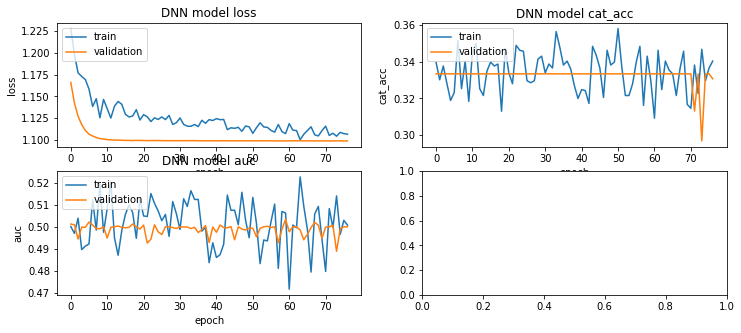

In [ ]:
model_DNN, history = createModel_DNN('DNN', X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
showResult(model_DNN, X_val_ts,y_val_ts)

24/24 [==============================] - 0s 5ms/step - loss: 1.0988 - cat_acc: 0.3333 - auc: 0.5000
[[246   0   0]
 [246   0   0]
 [246   0   0]]
Validation Score:  [1.0987839698791504, 0.3333333432674408, 0.5]
Validation Prediction: 
 [[0.33859575 0.3275057  0.3338985 ]
 [0.33883533 0.32732654 0.33383814]
 [0.33911917 0.32694587 0.333935  ]
 ...
 [0.33865407 0.32752183 0.33382413]
 [0.3381555  0.32812843 0.3337161 ]
 [0.33794552 0.32839128 0.33366317]]


## GRU

In [ ]:
def createModel_GRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(GRU(64,activation='tanh', return_sequences	=True))
    model.add(GRU(32,activation='tanh', return_sequences	=True))
    model.add(GRU(16,activation='tanh', return_sequences	=False))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (5169, 180, 148)
y_train.shape:  (5169, 3)
X_val.shape:  (2088, 180, 148)
y_val.shape:  (2088, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 180, 148)          0         
                                                                 
 gru_3 (GRU)                 (None, 180, 64)           41088     
                                                                 
 gru_4 (GRU)                 (None, 180, 32)           9408      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
      

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


162/162 [==============================] - 76s 419ms/step - loss: 0.8946 - cat_acc: 0.5579 - auc: 0.7869 - val_loss: 0.8918 - val_cat_acc: 0.6030 - val_auc: 0.7894
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.7810 - cat_acc: 0.6212 - auc: 0.8542

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


162/162 [==============================] - 63s 388ms/step - loss: 0.7810 - cat_acc: 0.6212 - auc: 0.8542 - val_loss: 0.7951 - val_cat_acc: 0.6034 - val_auc: 0.8383
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.7012 - cat_acc: 0.6968 - auc: 0.8778

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


162/162 [==============================] - 63s 393ms/step - loss: 0.7012 - cat_acc: 0.6968 - auc: 0.8778 - val_loss: 0.6885 - val_cat_acc: 0.7529 - val_auc: 0.8656
Epoch 4/100
162/162 [==============================] - ETA: 0s - loss: 0.6105 - cat_acc: 0.7584 - auc: 0.9105

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU.ckpt/assets


162/162 [==============================] - 64s 393ms/step - loss: 0.6105 - cat_acc: 0.7584 - auc: 0.9105 - val_loss: 0.6287 - val_cat_acc: 0.7577 - val_auc: 0.8952
Epoch 5/100
162/162 [==============================] - 48s 298ms/step - loss: 0.5404 - cat_acc: 0.7812 - auc: 0.9281 - val_loss: 0.6727 - val_cat_acc: 0.7170 - val_auc: 0.8768
Epoch 6/100
162/162 [==============================] - 48s 298ms/step - loss: 0.4767 - cat_acc: 0.8079 - auc: 0.9419 - val_loss: 0.8916 - val_cat_acc: 0.6777 - val_auc: 0.8293
Epoch 7/100
162/162 [==============================] - 49s 300ms/step - loss: 0.4554 - cat_acc: 0.8143 - auc: 0.9459 - val_loss: 0.8684 - val_cat_acc: 0.6892 - val_auc: 0.8440
Epoch 8/100
162/162 [==============================] - 49s 302ms/step - loss: 0.4200 - cat_acc: 0.8328 - auc: 0.9534 - val_loss: 0.7153 - val_cat_acc: 0.6916 - val_auc: 0.8707
Epoch 9/100
162/162 [==============================] - 49s 302ms/step - loss: 0.3832 - cat_acc: 0.8443 - auc: 0.9614 - val_loss: 1.0

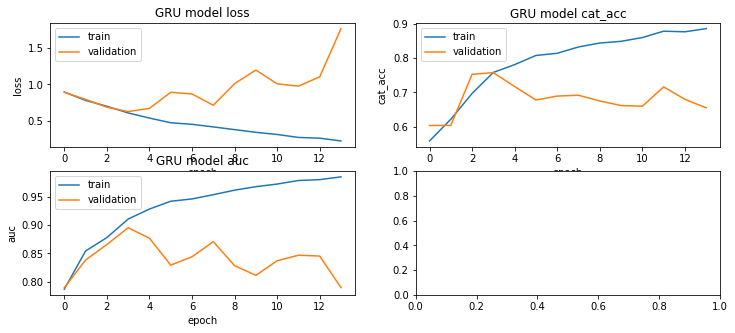

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'GRU'
model[modelName], history[modelName] = createModel_GRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'GRU'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

GRU : 
66/66 [==============================] - 4s 58ms/step - loss: 0.6287 - cat_acc: 0.7577 - auc: 0.8952
[[380 191 125]
 [144 552   0]
 [ 30  16 650]]
Validation Score:  [0.6286575198173523, 0.757662832736969, 0.8951550126075745]
Validation Prediction: 
 [[3.0105668e-01 1.7394410e-02 6.8154889e-01]
 [4.9670097e-01 1.4963214e-01 3.5366687e-01]
 [4.2136827e-01 4.1367647e-01 1.6495527e-01]
 ...
 [1.0057802e-02 2.4780243e-06 9.8993975e-01]
 [6.8786968e-03 9.7556892e-07 9.9312031e-01]
 [2.2810845e-02 1.8638350e-05 9.7717047e-01]]


## GRU adjust learning rate

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_43 (Dropout)        (None, 180, 96)           0         
                                                                 
 gru_3 (GRU)                 (None, 180, 64)           31104     
                                                                 
 gru_4 (GRU)                 (None, 180, 32)           9408      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 flatten_20 (Flatten)        (None, 16)                0         
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
       

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 59s 320ms/step - loss: 1.0792 - cat_acc: 0.3507 - auc: 0.5481 - val_loss: 1.0809 - val_cat_acc: 0.3333 - val_auc: 0.5619
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.9700 - cat_acc: 0.5072 - auc: 0.7127

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 33s 224ms/step - loss: 0.9700 - cat_acc: 0.5072 - auc: 0.7127 - val_loss: 1.0334 - val_cat_acc: 0.3608 - val_auc: 0.6310
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 0.8923 - cat_acc: 0.5988 - auc: 0.7959

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 34s 234ms/step - loss: 0.8923 - cat_acc: 0.5988 - auc: 0.7959 - val_loss: 0.9813 - val_cat_acc: 0.4774 - val_auc: 0.6951
Epoch 4/100
146/146 [==============================] - ETA: 0s - loss: 0.8085 - cat_acc: 0.6263 - auc: 0.8266

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 34s 235ms/step - loss: 0.8085 - cat_acc: 0.6263 - auc: 0.8266 - val_loss: 0.8580 - val_cat_acc: 0.6650 - val_auc: 0.8066
Epoch 5/100
146/146 [==============================] - ETA: 0s - loss: 0.7434 - cat_acc: 0.6433 - auc: 0.8445

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 33s 226ms/step - loss: 0.7434 - cat_acc: 0.6433 - auc: 0.8445 - val_loss: 0.8286 - val_cat_acc: 0.6582 - val_auc: 0.8126
Epoch 6/100
146/146 [==============================] - ETA: 0s - loss: 0.6956 - cat_acc: 0.6613 - auc: 0.8607

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 34s 234ms/step - loss: 0.6956 - cat_acc: 0.6613 - auc: 0.8607 - val_loss: 0.7377 - val_cat_acc: 0.7178 - val_auc: 0.8693
Epoch 7/100
146/146 [==============================] - ETA: 0s - loss: 0.6594 - cat_acc: 0.6851 - auc: 0.8739

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 34s 232ms/step - loss: 0.6594 - cat_acc: 0.6851 - auc: 0.8739 - val_loss: 0.7301 - val_cat_acc: 0.7169 - val_auc: 0.8667
Epoch 8/100
146/146 [==============================] - ETA: 0s - loss: 0.6404 - cat_acc: 0.6963 - auc: 0.8801

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/GRU_Alpha.ckpt/assets


146/146 [==============================] - 33s 227ms/step - loss: 0.6404 - cat_acc: 0.6963 - auc: 0.8801 - val_loss: 0.7109 - val_cat_acc: 0.7229 - val_auc: 0.8708
Epoch 9/100
146/146 [==============================] - 19s 127ms/step - loss: 0.6230 - cat_acc: 0.6980 - auc: 0.8861 - val_loss: 0.7168 - val_cat_acc: 0.6553 - val_auc: 0.8558
Epoch 10/100
146/146 [==============================] - 18s 126ms/step - loss: 0.6049 - cat_acc: 0.7044 - auc: 0.8920 - val_loss: 0.7240 - val_cat_acc: 0.6684 - val_auc: 0.8500
Epoch 11/100
146/146 [==============================] - 18s 127ms/step - loss: 0.5847 - cat_acc: 0.7205 - auc: 0.9006 - val_loss: 0.7312 - val_cat_acc: 0.6620 - val_auc: 0.8437
Epoch 12/100
146/146 [==============================] - 18s 126ms/step - loss: 0.5730 - cat_acc: 0.7178 - auc: 0.9042 - val_loss: 0.7428 - val_cat_acc: 0.6312 - val_auc: 0.8326
Epoch 13/100
146/146 [==============================] - 18s 126ms/step - loss: 0.5758 - cat_acc: 0.7190 - auc: 0.9026 - val_loss:

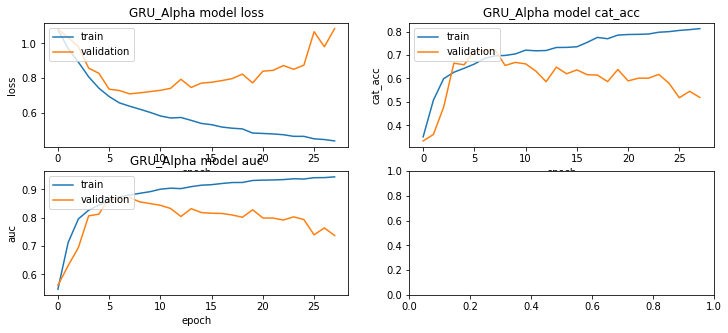

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'GRU_Alpha'
model[modelName], history[modelName] = createModel_GRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts ,learning_rate = 0.0001)

In [ ]:
modelName = 'GRU_Alpha'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

GRU_Alpha : 
74/74 [==============================] - 3s 45ms/step - loss: 0.7109 - cat_acc: 0.7229 - auc: 0.8708
[[543 246   0]
 [ 94 616  79]
 [  0 237 552]]
Validation Score:  [0.710906982421875, 0.7228559255599976, 0.8708365559577942]
Validation Prediction: 
 [[0.50336415 0.38778856 0.10884729]
 [0.61901575 0.3228613  0.05812287]
 [0.5616989  0.3666035  0.07169763]
 ...
 [0.0434422  0.48891044 0.4676473 ]
 [0.023259   0.40988335 0.56685764]
 [0.07950545 0.54145515 0.3790394 ]]


## Bidirectional LSTM

In [ ]:
def createModel_BiLSTM(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(64,activation='tanh', return_sequences	=True)))
    model.add(Bidirectional(LSTM(32,activation='tanh', return_sequences	=True)))
    model.add(Bidirectional(LSTM(16,activation='tanh', return_sequences	=False)))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 180, 96)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 180, 128)         82432     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 180, 64)          41216     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 flatten (

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


146/146 [==============================] - 131s 814ms/step - loss: 0.8861 - cat_acc: 0.5520 - auc: 0.7575 - val_loss: 1.2662 - val_cat_acc: 0.4415 - val_auc: 0.6715
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.6383 - cat_acc: 0.6959 - auc: 0.8821

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


146/146 [==============================] - 117s 801ms/step - loss: 0.6383 - cat_acc: 0.6959 - auc: 0.8821 - val_loss: 0.8286 - val_cat_acc: 0.6299 - val_auc: 0.8176
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 0.5575 - cat_acc: 0.7457 - auc: 0.9099

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM.ckpt/assets


146/146 [==============================] - 116s 797ms/step - loss: 0.5575 - cat_acc: 0.7457 - auc: 0.9099 - val_loss: 0.7624 - val_cat_acc: 0.6489 - val_auc: 0.8378
Epoch 4/100
146/146 [==============================] - 72s 493ms/step - loss: 0.4986 - cat_acc: 0.7740 - auc: 0.9277 - val_loss: 0.8312 - val_cat_acc: 0.5154 - val_auc: 0.7705
Epoch 5/100
146/146 [==============================] - 88s 601ms/step - loss: 0.4676 - cat_acc: 0.7980 - auc: 0.9389 - val_loss: 0.9268 - val_cat_acc: 0.5087 - val_auc: 0.7581
Epoch 6/100
146/146 [==============================] - 72s 496ms/step - loss: 0.4359 - cat_acc: 0.8100 - auc: 0.9459 - val_loss: 0.9339 - val_cat_acc: 0.5213 - val_auc: 0.7388
Epoch 7/100
146/146 [==============================] - 72s 493ms/step - loss: 0.4040 - cat_acc: 0.8276 - auc: 0.9543 - val_loss: 0.8687 - val_cat_acc: 0.5868 - val_auc: 0.8115
Epoch 8/100
146/146 [==============================] - 72s 491ms/step - loss: 0.3665 - cat_acc: 0.8558 - auc: 0.9617 - val_loss: 1.

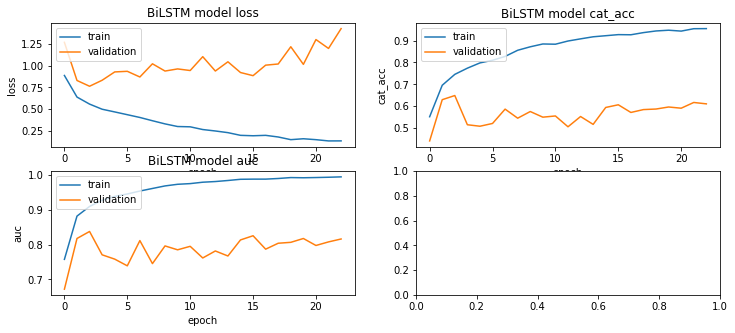

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'BiLSTM'
model[modelName], history[modelName] = createModel_BiLSTM(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'BiLSTM'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

BiLSTM : 
74/74 [==============================] - 8s 108ms/step - loss: 0.7624 - cat_acc: 0.6489 - auc: 0.8378
[[383 406   0]
 [ 82 608  99]
 [  0 244 545]]
Validation Score:  [0.7623761296272278, 0.6489226818084717, 0.8378103375434875]
Validation Prediction: 
 [[0.35955006 0.6017607  0.03868933]
 [0.63016814 0.3643551  0.00547677]
 [0.2630544  0.65824705 0.07869854]
 ...
 [0.03207684 0.54490656 0.42301655]
 [0.0287705  0.5326151  0.43861446]
 [0.03518885 0.5591444  0.4056667 ]]


## Bidirectional LSTM (sum)

In [ ]:
def createModel_BiLSTM2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(64,activation='tanh', return_sequences	=True),merge_mode='sum'))
    model.add(Bidirectional(LSTM(32,activation='tanh', return_sequences	=True),merge_mode='sum'))
    model.add(Bidirectional(LSTM(16,activation='tanh', return_sequences	=False),merge_mode='sum'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 180, 96)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 180, 64)          82432     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 180, 32)          24832     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 16)               6272      
 nal)                                                            
                                                                 
 flatten

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


146/146 [==============================] - 136s 838ms/step - loss: 0.8975 - cat_acc: 0.5651 - auc: 0.7558 - val_loss: 1.0510 - val_cat_acc: 0.3676 - val_auc: 0.6662
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.6431 - cat_acc: 0.7085 - auc: 0.8806

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


146/146 [==============================] - 114s 786ms/step - loss: 0.6431 - cat_acc: 0.7085 - auc: 0.8806 - val_loss: 0.8734 - val_cat_acc: 0.5327 - val_auc: 0.7625
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 0.5627 - cat_acc: 0.7495 - auc: 0.9086

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiLSTM2.ckpt/assets


146/146 [==============================] - 115s 788ms/step - loss: 0.5627 - cat_acc: 0.7495 - auc: 0.9086 - val_loss: 0.8014 - val_cat_acc: 0.5551 - val_auc: 0.8117
Epoch 4/100
146/146 [==============================] - 69s 476ms/step - loss: 0.4925 - cat_acc: 0.7847 - auc: 0.9308 - val_loss: 0.8589 - val_cat_acc: 0.5361 - val_auc: 0.7847
Epoch 5/100
146/146 [==============================] - 69s 474ms/step - loss: 0.4668 - cat_acc: 0.7982 - auc: 0.9377 - val_loss: 0.8272 - val_cat_acc: 0.5294 - val_auc: 0.7852
Epoch 6/100
146/146 [==============================] - 69s 472ms/step - loss: 0.4472 - cat_acc: 0.8120 - auc: 0.9441 - val_loss: 1.0349 - val_cat_acc: 0.4812 - val_auc: 0.7396
Epoch 7/100
146/146 [==============================] - 69s 474ms/step - loss: 0.3866 - cat_acc: 0.8371 - auc: 0.9576 - val_loss: 1.1337 - val_cat_acc: 0.5061 - val_auc: 0.7309
Epoch 8/100
146/146 [==============================] - 69s 475ms/step - loss: 0.3790 - cat_acc: 0.8452 - auc: 0.9594 - val_loss: 0.

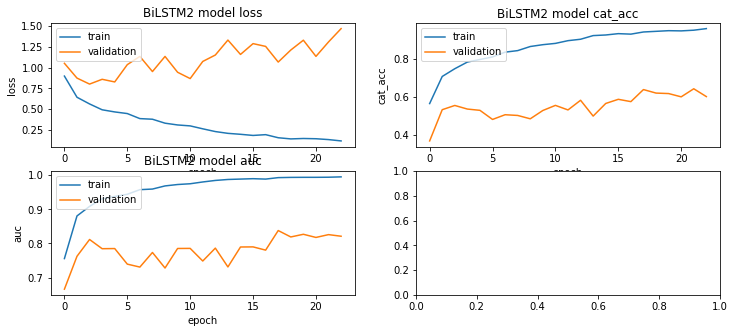

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'BiLSTM2'
model[modelName], history[modelName] = createModel_BiLSTM2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'BiLSTM2'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

BiLSTM2 : 
74/74 [==============================] - 8s 103ms/step - loss: 0.8014 - cat_acc: 0.5551 - auc: 0.8117
[[381 408   0]
 [ 84 705   0]
 [  0 561 228]]
Validation Score:  [0.8013604879379272, 0.5551331043243408, 0.8116917014122009]
Validation Prediction: 
 [[0.11246212 0.7156945  0.17184338]
 [0.2083605  0.72561204 0.06602746]
 [0.16139679 0.72586244 0.11274072]
 ...
 [0.11763097 0.65417176 0.2281973 ]
 [0.12365725 0.6515097  0.22483298]
 [0.13892013 0.658765   0.20231481]]


## Bidirectional GRU

In [ ]:
def createModel_BiGRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(Bidirectional(GRU(64,activation='tanh', return_sequences	=True)))
    model.add(Bidirectional(GRU(32,activation='tanh', return_sequences	=True)))
    model.add(Bidirectional(GRU(16,activation='tanh', return_sequences	=False)))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 180, 96)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 180, 128)         62208     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 180, 64)          31104     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 flatten

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


146/146 [==============================] - 133s 820ms/step - loss: 0.8457 - cat_acc: 0.5686 - auc: 0.7901 - val_loss: 0.7884 - val_cat_acc: 0.6591 - val_auc: 0.8384
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.6573 - cat_acc: 0.6907 - auc: 0.8786

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


146/146 [==============================] - 115s 791ms/step - loss: 0.6573 - cat_acc: 0.6907 - auc: 0.8786 - val_loss: 0.6810 - val_cat_acc: 0.7191 - val_auc: 0.8905
Epoch 3/100
146/146 [==============================] - 73s 499ms/step - loss: 0.5654 - cat_acc: 0.7426 - auc: 0.9127 - val_loss: 0.6949 - val_cat_acc: 0.6553 - val_auc: 0.8611
Epoch 4/100
146/146 [==============================] - 73s 497ms/step - loss: 0.5227 - cat_acc: 0.8085 - auc: 0.9264 - val_loss: 0.8439 - val_cat_acc: 0.5957 - val_auc: 0.7999
Epoch 5/100
146/146 [==============================] - 72s 494ms/step - loss: 0.4673 - cat_acc: 0.8253 - auc: 0.9409 - val_loss: 0.7282 - val_cat_acc: 0.6861 - val_auc: 0.8528
Epoch 6/100
146/146 [==============================] - 72s 496ms/step - loss: 0.4110 - cat_acc: 0.8493 - auc: 0.9545 - val_loss: 0.7128 - val_cat_acc: 0.6569 - val_auc: 0.8550
Epoch 7/100
146/146 [==============================] - ETA: 0s - loss: 0.3647 - cat_acc: 0.8792 - auc: 0.9648

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU.ckpt/assets


146/146 [==============================] - 114s 784ms/step - loss: 0.3647 - cat_acc: 0.8792 - auc: 0.9648 - val_loss: 0.6709 - val_cat_acc: 0.6891 - val_auc: 0.8785
Epoch 8/100
146/146 [==============================] - 74s 506ms/step - loss: 0.3475 - cat_acc: 0.8841 - auc: 0.9678 - val_loss: 0.7930 - val_cat_acc: 0.6388 - val_auc: 0.8319
Epoch 9/100
146/146 [==============================] - 74s 504ms/step - loss: 0.3110 - cat_acc: 0.9090 - auc: 0.9752 - val_loss: 0.9345 - val_cat_acc: 0.5877 - val_auc: 0.8042
Epoch 10/100
146/146 [==============================] - 73s 501ms/step - loss: 0.2782 - cat_acc: 0.9165 - auc: 0.9793 - val_loss: 1.0304 - val_cat_acc: 0.5399 - val_auc: 0.7787
Epoch 11/100
146/146 [==============================] - 73s 498ms/step - loss: 0.2763 - cat_acc: 0.9223 - auc: 0.9802 - val_loss: 0.7972 - val_cat_acc: 0.6777 - val_auc: 0.8424
Epoch 12/100
146/146 [==============================] - 73s 500ms/step - loss: 0.2238 - cat_acc: 0.9429 - auc: 0.9869 - val_loss:

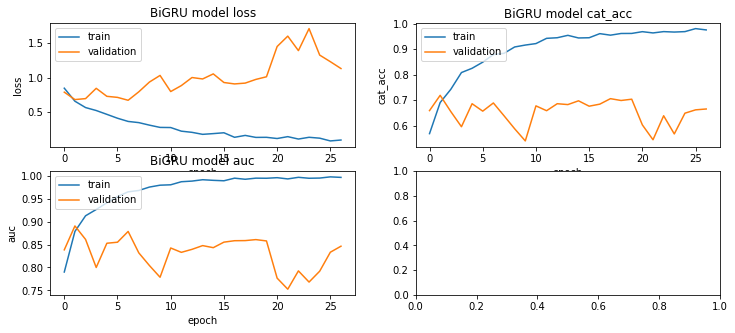

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'BiGRU'
model[modelName], history[modelName] = createModel_BiGRU(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts )

In [ ]:
modelName = 'BiGRU'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

BiGRU : 
74/74 [==============================] - 7s 98ms/step - loss: 0.6709 - cat_acc: 0.6891 - auc: 0.8785
[[460 322   7]
 [ 79 530 180]
 [  0 148 641]]
Validation Score:  [0.6708849668502808, 0.6890578866004944, 0.8785090446472168]
Validation Prediction: 
 [[8.26152503e-01 1.73466519e-01 3.80981917e-04]
 [9.14733946e-01 8.52536708e-02 1.23695927e-05]
 [5.33552408e-01 4.63080496e-01 3.36701307e-03]
 ...
 [1.11855725e-02 5.67912944e-02 9.32023108e-01]
 [1.81809925e-02 7.95524493e-02 9.02266622e-01]
 [4.23475504e-02 1.41257867e-01 8.16394627e-01]]


## Bidirectional LSTM (sum)

In [ ]:
def createModel_BiGRU2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts , epochs=100, learning_rate = 0.001):
    print('X_train.shape: ',X_train_ts.shape)
    print('y_train.shape: ',y_train_ts.shape)
    print('X_val.shape: ',X_val_ts.shape)
    print('y_val.shape: ',y_val_ts.shape)
    
    filepath = os.path.join(DL_DIR,modelName+ ".ckpt")
    look_back = X_train_ts.shape[1]
    n_feat = X_train_ts.shape[2]

    # # Prepocessing
    # normalizer = Normalization()
    # normalizer.adapt(X_train_ts)

    # Model
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.InputLayer(input_shape=(look_back, n_feat)))
    # model.add( normalizer)

    model.add(Dropout(0.1))
    model.add(Bidirectional(GRU(64,activation='tanh', return_sequences	=True),merge_mode='sum'))
    model.add(Bidirectional(GRU(32,activation='tanh', return_sequences	=True),merge_mode='sum'))
    model.add(Bidirectional(GRU(16,activation='tanh', return_sequences	=False),merge_mode='sum'))

    model.add(Flatten())

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 128 , activation = 'relu', name='Dense0'))
    model.add(layers.Dense(units = 64 , activation = 'relu', name='Dense1'))
    model.add(layers.Dense(units = 32 , activation = 'relu', name='Dense2'))
    model.add(layers.Dense(units = 16 , activation = 'relu', name='Dense3'))
    model.add(layers.Dense(units = 8  , activation = 'relu', name='Dense4'))

    model.add(Dropout(0.2))
    model.add(layers.Dense(units = 3 , activation = 'softmax', name='head'))

    METRICS = [
          metrics.CategoricalAccuracy(name='cat_acc'),
          metrics.AUC(name='auc'),
    ]

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
            loss = 'categorical_crossentropy',
            metrics = METRICS
    )
    model.summary()

    es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', 
                            baseline=None, restore_best_weights=True)

    callbacks = [ es_callback, ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]  


    history = model.fit(X_train_ts, y_train_ts,#steps_per_epoch=100,
                     epochs=epochs, verbose=1,callbacks = callbacks,  validation_data=(X_val_ts, y_val_ts)) 
    _=plotTrain( history, modelName, ['cat_acc','auc'])
    return model, history

X_train.shape:  (4659, 180, 96)
y_train.shape:  (4659, 3)
X_val.shape:  (2367, 180, 96)
y_val.shape:  (2367, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 180, 96)           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 180, 64)          62208     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 180, 32)          18816     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 16)               4800      
 onal)                                                           
                                                                 
 flatten

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


146/146 [==============================] - 130s 798ms/step - loss: 1.0766 - cat_acc: 0.4254 - auc: 0.6039 - val_loss: 1.0975 - val_cat_acc: 0.3405 - val_auc: 0.5248
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 0.9476 - cat_acc: 0.5651 - auc: 0.7580

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


146/146 [==============================] - 114s 780ms/step - loss: 0.9476 - cat_acc: 0.5651 - auc: 0.7580 - val_loss: 1.0298 - val_cat_acc: 0.4364 - val_auc: 0.6524
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 0.8100 - cat_acc: 0.6205 - auc: 0.8149

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


146/146 [==============================] - 114s 784ms/step - loss: 0.8100 - cat_acc: 0.6205 - auc: 0.8149 - val_loss: 0.8971 - val_cat_acc: 0.5822 - val_auc: 0.7814
Epoch 4/100
146/146 [==============================] - ETA: 0s - loss: 0.7345 - cat_acc: 0.6557 - auc: 0.8469

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IAQF - Five+1 Guys/2022/Colab/Deep Learning/BiGRU2.ckpt/assets


146/146 [==============================] - 111s 759ms/step - loss: 0.7345 - cat_acc: 0.6557 - auc: 0.8469 - val_loss: 0.8213 - val_cat_acc: 0.6105 - val_auc: 0.8268
Epoch 5/100
146/146 [==============================] - 68s 469ms/step - loss: 0.6784 - cat_acc: 0.6881 - auc: 0.8699 - val_loss: 0.8258 - val_cat_acc: 0.5910 - val_auc: 0.8066
Epoch 6/100
146/146 [==============================] - 72s 492ms/step - loss: 0.6620 - cat_acc: 0.6971 - auc: 0.8754 - val_loss: 0.9449 - val_cat_acc: 0.4973 - val_auc: 0.7209
Epoch 7/100
146/146 [==============================] - 70s 478ms/step - loss: 0.6180 - cat_acc: 0.7216 - auc: 0.8933 - val_loss: 0.9219 - val_cat_acc: 0.5125 - val_auc: 0.7383
Epoch 8/100
146/146 [==============================] - 70s 478ms/step - loss: 0.6044 - cat_acc: 0.7306 - auc: 0.8979 - val_loss: 1.0532 - val_cat_acc: 0.4622 - val_auc: 0.6762
Epoch 9/100
146/146 [==============================] - 69s 476ms/step - loss: 0.5816 - cat_acc: 0.7482 - auc: 0.9053 - val_loss: 1.

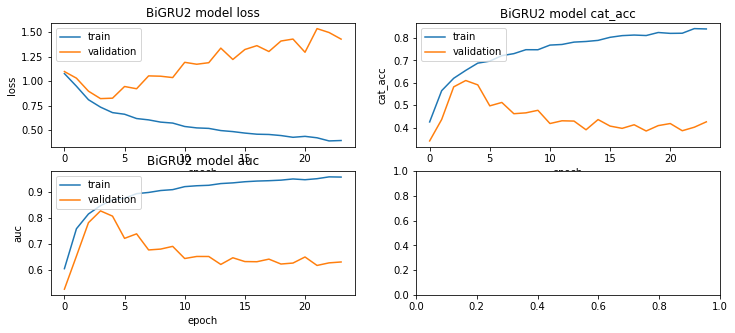

In [ ]:
# model_GRU, history = createModel_GRU('GRU', X_train_ts, y_train_ts,X_val_ts, y_val_ts )
modelName = 'BiGRU2'
model[modelName], history[modelName] = createModel_BiGRU2(modelName, X_train_ts, y_train_ts,X_val_ts, y_val_ts, learning_rate= 0.0001 )

In [ ]:
modelName = 'BiGRU2'
print(modelName,': ')
showResult(model[modelName], X_val_ts,y_val_ts)

BiGRU2 : 
74/74 [==============================] - 7s 95ms/step - loss: 0.8213 - cat_acc: 0.6105 - auc: 0.8268
[[524 265   0]
 [286 415  88]
 [  9 274 506]]
Validation Score:  [0.8212535977363586, 0.6104773879051208, 0.8267794847488403]
Validation Prediction: 
 [[0.3846404  0.48175794 0.13360174]
 [0.51208085 0.4014587  0.08646051]
 [0.4745318  0.4235671  0.10190109]
 ...
 [0.21112235 0.35811898 0.43075866]
 [0.22291496 0.37359354 0.40349147]
 [0.23426898 0.40398735 0.3617437 ]]


# Backtesting

In [ ]:
def pred_threshold(y_pred, threshold):
  return np.array([(p>threshold).argmax() if (p>threshold).any() else 1 for p in y_pred])-1

In [ ]:
def pred_state_threshold(y_pred, threshold):
  init_state = 0
  pred = []
  for i in range(len(y_pred)):
    if (y_pred[i]>=threshold).any():
      pred_state = y_pred[i].argmax()-1
    else:
      pred_state = init_state
    init_state = pred_state
    pred.append(pred_state)
  return np.array(pred)

In [ ]:
def pred_HMMstate_threshold(y_pred, threshold, y_true):
  init_state = 0
  pred = [y_pred[0].argmax()-1 if (y_pred[0]>=threshold).any() else init_state ]
  for i in range(1,len(y_pred)):
    prev_HMM_state = y_true[i-1]
    if (y_pred[i]>=threshold).any():
      pred_state = y_pred[i].argmax()-1
    else:
      pred_state = prev_HMM_state
    pred.append(pred_state)
  return np.array(pred)

In [ ]:
modelName = 'GRU'
model_used = model[modelName]

close_name = 'PX_LAST'
# targetLabel = 'POS_SR'
# Target = targetLabel
Target_Pred = targetLabel+'_Predict'



In [ ]:
y_pred = model_used.predict(X_val_ts_raw)
pred = y_pred.argmax(axis=1)-1

data = df.loc[val_date,['PX_LAST',Target]]
data[Target_Pred+'_argmax'] = pred


In [ ]:
pred2 = pred_threshold(y_pred, 0.7)
data[Target_Pred+'_th.7'] = pred2

In [ ]:
pred3 = pred_state_threshold(y_pred, threshold = 0.7)
data[Target_Pred+'_sth.7'] = pred3

In [ ]:
pred4 =  pred_HMMstate_threshold(y_pred, threshold = 0.7, y_true = data[Target])
data[Target_Pred+'_HSth.7'] = pred4

In [ ]:
# print(confusion_matrix( data[Target], data[Target_Pred+'2'] ) ) 

In [ ]:
data

,PX_LAST,hmm2_MA10_shifted,hmm2_MA10_Predict_argmax,hmm2_MA10_Predict_th.7,hmm2_MA10_Predict_sth.7,hmm2_MA10_Predict_HSth.7
Date,,,,,,
2014-09-18,5785.40,1.0,1,1,1,1.0
2014-09-19,5775.62,1.0,1,1,1,1.0
2014-09-22,5720.95,1.0,1,0,1,1.0
2014-09-23,5685.86,1.0,-1,0,1,1.0
2014-09-24,5729.91,-1.0,1,0,1,1.0
...,...,...,...,...,...,...
2017-12-22,8185.44,1.0,1,1,1,1.0
2017-12-26,8179.36,1.0,1,1,1,1.0
2017-12-27,8185.85,1.0,1,1,1,1.0


In [ ]:
print('Target label - '+Target)
bt,stat,data_temp = backtesting_df(data, close_name, Target,commission=0.0005)

Target label - hmm2_MA10_shifted
              Close  State     Open     High      Low
Date                                                 
2014-09-18  5785.40    1.0  5785.40  5785.40  5785.40
2014-09-19  5775.62    1.0  5775.62  5775.62  5775.62
2014-09-22  5720.95    1.0  5720.95  5720.95  5720.95
2014-09-23  5685.86    1.0  5685.86  5685.86  5685.86
2014-09-24  5729.91   -1.0  5729.91  5729.91  5729.91


Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   97.342995
Equity Final [$]                3748325.36103
Equity Peak [$]                 3748325.36103
Return [%]                         274.832536
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                   49.501699
Volatility (Ann.) [%]               16.748704
Sharpe Ratio                         2.955554
Sortino Ratio                        8.384068
Calmar Ratio                         9.492715
Max. Drawdown [%]                   -5.214704
Avg. Drawdown [%]                   -0.812635
Max. Drawdown Duration       57 days 00:00:00
Avg. Drawdown Duration        9 days 00:00:00
# Trades                                   53
Win Rate [%]                        90.566038
Best Trade [%]                      14.216171
Worst Trade [%]                     -1.008994
Avg. Trade [%]                    

In [ ]:
print('Target label - '+Target_Pred+'_argmax')
bt,stat,data_temp = backtesting_df(data, close_name, Target_Pred+'_argmax',commission=0.0005)

Target label - hmm2_MA10_Predict_argmax
              Close  State     Open     High      Low
Date                                                 
2014-09-18  5785.40      1  5785.40  5785.40  5785.40
2014-09-19  5775.62      1  5775.62  5775.62  5775.62
2014-09-22  5720.95      1  5720.95  5720.95  5720.95
2014-09-23  5685.86     -1  5685.86  5685.86  5685.86
2014-09-24  5729.91      1  5729.91  5729.91  5729.91


Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   94.806763
Equity Final [$]                1003630.55945
Equity Peak [$]                1054445.374395
Return [%]                           0.363056
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                    0.110356
Volatility (Ann.) [%]               11.002856
Sharpe Ratio                          0.01003
Sortino Ratio                        0.013752
Calmar Ratio                         0.004698
Max. Drawdown [%]                  -23.490326
Avg. Drawdown [%]                   -3.760126
Max. Drawdown Duration     1120 days 00:00:00
Avg. Drawdown Duration      148 days 00:00:00
# Trades                                   78
Win Rate [%]                        34.615385
Best Trade [%]                      11.636538
Worst Trade [%]                     -3.685217
Avg. Trade [%]                    

In [ ]:
pred_name = Target_Pred+'_th.7'
print('Target label - '+pred_name)
bt,stat,data_temp = backtesting_df(data, close_name, pred_name,commission=0.0005)

Target label - hmm2_MA10_Predict_th.7
              Close  State     Open     High      Low
Date                                                 
2014-09-18  5785.40      1  5785.40  5785.40  5785.40
2014-09-19  5775.62      1  5775.62  5775.62  5775.62
2014-09-22  5720.95      0  5720.95  5720.95  5720.95
2014-09-23  5685.86      0  5685.86  5685.86  5685.86
2014-09-24  5729.91      0  5729.91  5729.91  5729.91


Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   76.449275
Equity Final [$]                1019460.31522
Equity Peak [$]                  1063908.3902
Return [%]                           1.946032
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                    0.588305
Volatility (Ann.) [%]                7.888555
Sharpe Ratio                         0.074577
Sortino Ratio                        0.100145
Calmar Ratio                          0.02863
Max. Drawdown [%]                  -20.548549
Avg. Drawdown [%]                   -2.850971
Max. Drawdown Duration     1120 days 00:00:00
Avg. Drawdown Duration      144 days 00:00:00
# Trades                                   49
Win Rate [%]                        36.734694
Best Trade [%]                      10.643011
Worst Trade [%]                     -2.666276
Avg. Trade [%]                    

In [ ]:
pred_name = Target_Pred+'_sth.7'
print('Target label - '+pred_name)
bt,stat,data_temp = backtesting_df(data, close_name, pred_name,commission=0.0005)

Target label - hmm2_MA10_Predict_sth.7
              Close  State     Open     High      Low
Date                                                 
2014-09-18  5785.40      1  5785.40  5785.40  5785.40
2014-09-19  5775.62      1  5775.62  5775.62  5775.62
2014-09-22  5720.95      1  5720.95  5720.95  5720.95
2014-09-23  5685.86      1  5685.86  5685.86  5685.86
2014-09-24  5729.91      1  5729.91  5729.91  5729.91


Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   89.251208
Equity Final [$]               1170849.482755
Equity Peak [$]                1170849.482755
Return [%]                          17.084948
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                    4.917553
Volatility (Ann.) [%]               11.411437
Sharpe Ratio                         0.430932
Sortino Ratio                        0.622725
Calmar Ratio                         0.219617
Max. Drawdown [%]                  -22.391495
Avg. Drawdown [%]                   -1.592494
Max. Drawdown Duration      876 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   12
Win Rate [%]                             50.0
Best Trade [%]                      14.119201
Worst Trade [%]                     -9.008118
Avg. Trade [%]                    

In [ ]:
pred_name = Target_Pred+'_HSth.7'
print('Target label - '+pred_name)
bt,stat,data_temp = backtesting_df(data, close_name, pred_name,commission=0.0005)

Target label - hmm2_MA10_Predict_HSth.7
              Close  State     Open     High      Low
Date                                                 
2014-09-18  5785.40    1.0  5785.40  5785.40  5785.40
2014-09-19  5775.62    1.0  5775.62  5775.62  5775.62
2014-09-22  5720.95    1.0  5720.95  5720.95  5720.95
2014-09-23  5685.86    1.0  5685.86  5685.86  5685.86
2014-09-24  5729.91    1.0  5729.91  5729.91  5729.91


Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   95.772947
Equity Final [$]               1052490.579095
Equity Peak [$]                1052490.579095
Return [%]                           5.249058
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                    1.569208
Volatility (Ann.) [%]               11.449769
Sharpe Ratio                         0.137051
Sortino Ratio                        0.192987
Calmar Ratio                         0.068828
Max. Drawdown [%]                  -22.798852
Avg. Drawdown [%]                   -3.437775
Max. Drawdown Duration     1089 days 00:00:00
Avg. Drawdown Duration      130 days 00:00:00
# Trades                                   46
Win Rate [%]                         28.26087
Best Trade [%]                      11.636538
Worst Trade [%]                      -3.41783
Avg. Trade [%]                    

In [ ]:
confusion_matrix(data[Target], data[ Target_Pred+'_HSth.7'])

array([[ 47,  17,  19],
       [ 23,  25,   1],
       [  1,  19, 676]])

In [ ]:
pd.DataFrame(train_date).to_csv(os.path.join(LABEL_DIR,'train_date.csv'))
pd.DataFrame(val_date).to_csv(os.path.join(LABEL_DIR,'val_date.csv'))
pd.DataFrame(test_date).to_csv(os.path.join(LABEL_DIR,'test_date.csv'))

In [ ]:
stat[['Return [%]','Sharpe Ratio' ]]

Return [%]      5.249058
Sharpe Ratio    0.137051
dtype: object

In [ ]:
stat

Start                     2014-09-18 00:00:00
End                       2017-12-29 00:00:00
Duration                   1198 days 00:00:00
Exposure Time [%]                   95.772947
Equity Final [$]               1052490.579095
Equity Peak [$]                1052490.579095
Return [%]                           5.249058
Buy & Hold Return [%]               41.059909
Return (Ann.) [%]                    1.569208
Volatility (Ann.) [%]               11.449769
Sharpe Ratio                         0.137051
Sortino Ratio                        0.192987
Calmar Ratio                         0.068828
Max. Drawdown [%]                  -22.798852
Avg. Drawdown [%]                   -3.437775
Max. Drawdown Duration     1089 days 00:00:00
Avg. Drawdown Duration      130 days 00:00:00
# Trades                                   46
Win Rate [%]                         28.26087
Best Trade [%]                      11.636538
Worst Trade [%]                      -3.41783
Avg. Trade [%]                    